In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

from mrcnn.utils import Dataset
from matplotlib import pyplot as plt

from mrcnn.config import Config
import glob

In [2]:
import math


class CustomDataset(Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the custom dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes according to the numbe of classes required to detect
        self.add_class("custom", 1, "irregular_organiod")
 
        master_annotations = json.load(open(r"E:\mask_rcnn\annotations\irregular_annotations.json"))
        master_annotations = list(master_annotations.values())  # don't need the dict keys

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        #dataset_dir = os.path.join(dataset_dir, subset)
        images_in_dir = os.listdir(dataset_dir)

        # find annotations for images in dir
        for image in images_in_dir:
            for annotation in master_annotations:
                # check if image exists
                filename = annotation['filename']
                image_path = os.path.join(dataset_dir, filename)
                if os.path.isfile(image_path) == True:
                    if len(annotation['regions']) == 0:
                        filename = annotation['filename']
                        image_path = os.path.join(dataset_dir, filename)
                        os.remove(image_path)
                        #break
                        #break
                    if annotation['filename'] == image:
                        #if matched get info
                        filename = annotation['filename']

                        #load image to get its size
                        image_path = os.path.join(dataset_dir, filename)
                        image_loaded = skimage.io.imread(image_path)
                        height, width = image_loaded.shape[:2]

                        image_annotations = annotation['regions']
                        num_ids = [1] * len(image_annotations)
                        polygon_list = []
                        for a in image_annotations:
                            polygon_list.append(a['shape_attributes'])

                        print('adding image: ', filename)
                        self.add_image(
                            "custom",
                            image_id=filename,  # use file name as a unique image id
                            path=image_path,
                            width=width, height=height,
                            polygons=polygon_list,
                            num_ids=num_ids)
                    
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a custom dataset image, delegate to parent class.
        info = self.image_info[image_id]

        num_ids = info['num_ids']
        #print("Here is the numID",num_ids)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        #generate empty mask
        mask = np.zeros([info["height"], info["width"], len(num_ids)],
                        dtype=np.uint8)
        def radian_to_deg(x):
            return x * 180/math.pi

        for i, p in enumerate( info['polygons']):

            if p['name'] == 'ellipse':  
                cx = int(p['cx'])
                cy = int(p['cy'])
                center = (cx,cy)
                rx = int(p['rx'])
                ry = int(p['ry'])
                axes = (rx,ry)
                if 'theta' in p:
                    thetaa = math.pi - p['theta']
                else:
                    thetaa = 0
                

                rr, cc = skimage.draw.ellipse(cy, cx, ry, rx, rotation = thetaa)

                #on the off chance that some masks fall exactly on the border, fix mask value
                rr[rr > mask.shape[0]-1] = mask.shape[0]-1
                cc[cc > mask.shape[1]-1] = mask.shape[1]-1

                mask[rr,cc,i] = 1
            if p['name'] == 'circle':
                cx = int(p['cx'])
                cy = int(p['cy'])
                center = (cx,cy) 
                radius = int(p['r'])
                rr, cc = skimage.draw.circle(cy,cx, radius)
                #on the off chance that some masks fall exactly on the border, fix mask value
                rr[rr > mask.shape[0]-1] = mask.shape[0]-1
                cc[cc > mask.shape[1]-1] = mask.shape[1]-1
                mask[rr,cc,i] = 1
            if p['name'] == 'polyline':
                rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
                #on the off chance that some masks fall exactly on the border, fix mask value
                rr[rr > mask.shape[0]-1] = mask.shape[0]-1
                cc[cc > mask.shape[1]-1] = mask.shape[1]-1
                mask[rr, cc, i] = 1


        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        num_ids = np.array(num_ids, dtype=np.int32)	
        return mask, num_ids 
    
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = cv2.imread(self.image_info[image_id]['path'], cv2.IMREAD_GRAYSCALE)
        image = np.expand_dims(image, axis=-1).astype(np.uint8)
        return image
    
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "custom":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)




            

     
        

In [3]:
import shutil
import random
# split dataset between training and validation random


dataset_dir = os.path.join(r"E:\mask_rcnn\irregular_images", "full")
#dataset_dir = os.path.join(dataset_dir, subset)
images_in_dir = os.listdir(dataset_dir)
images_in_dir = [os.path.join("E:/mask_rcnn/irregular_images/full/", x) for x in images_in_dir]


# randomly shuffle the data 

random.shuffle(images_in_dir)
train_data = images_in_dir[:int((len(images_in_dir)+1)*.80)] #Remaining 80% to training set
val_data = images_in_dir[int((len(images_in_dir)+1)*.80):] #Splits 20% data to test set

# define destination folders
training_path_folder = os.path.join(r"E:\mask_rcnn\irregular_images", "train")
validation_path_folder = os.path.join(r"E:\mask_rcnn\irregular_images", "val")
# move files

for f in train_data:
    shutil.move(f, training_path_folder)
for f in val_data:
    shutil.move(f, validation_path_folder)

In [3]:
# find mean pixel in images
from numpy import mean
import cv2
dataset_dir = os.path.join(r"E:\mask_rcnn\irregular_images", "train")
images_in_dir = os.listdir(dataset_dir)
images_in_dir = [os.path.join("E:/mask_rcnn/irregular_images/train/", x) for x in images_in_dir]
mean_pixel_values_training = [mean(cv2.imread(x,cv2.IMREAD_GRAYSCALE)) for x in images_in_dir]

dataset_dir = os.path.join(r"E:\mask_rcnn\irregular_images", "val")
images_in_dir = os.listdir(dataset_dir)
images_in_dir = [os.path.join("E:/mask_rcnn/irregular_images/val/", x) for x in images_in_dir]
mean_pixel_values_val = [mean(cv2.imread(x,cv2.IMREAD_GRAYSCALE)) for x in images_in_dir]


overall_mean_pixel_value = mean(mean_pixel_values_training + mean_pixel_values_val)

In [5]:
# code to fix the annotations file

master_annotations = json.load(open(r"E:\mask_rcnn\annotations\irregular_annotations.json"))
dict_keys = list(master_annotations.keys())
master_annotations = list(master_annotations.values())  # don't need the dict keys

def removeduplicate(it):
    seen = []
    for x in it:
        if x not in seen:
            yield x
            seen.append(x)
    

for annotation in master_annotations:
    annotation['regions'] = list(removeduplicate(annotation['regions']))


fixed_annotations = dict(zip(dict_keys, master_annotations))

#save updated annotations
with open("E:/mask_rcnn/annotations/irregular_annotations.json", "w") as outfile:
    json.dump(fixed_annotations, outfile)



In [4]:
from mrcnn.visualize import display_instances
#load the training dataset

dataset_train = CustomDataset()
dataset_train.load_custom(r"E:\mask_rcnn\irregular_images", "train") 
dataset_train.prepare()
print('Train: %d' % len(dataset_train.image_ids))


# define image id
#n = random.randint(0,len(dataset_train.image_ids)-1)
    

adding image:  Subsetir0_512x512_008.jpg
adding image:  Subsetir0_512x512_009.jpg
adding image:  Subsetir0_512x512_011.jpg
adding image:  Subsetir0_512x512_012.jpg
adding image:  Subsetir0_512x512_015.jpg
adding image:  Subsetir0_512x512_016.jpg
adding image:  Subsetir0_512x512_017.jpg
adding image:  Subsetir0_512x512_018.jpg
adding image:  Subsetir0_512x512_019.jpg
adding image:  Subsetir0_512x512_020.jpg
adding image:  Subsetir0_512x512_022.jpg
adding image:  Subsetir0_512x512_024.jpg
adding image:  Subsetir0_512x512_025.jpg
adding image:  Subsetir0_512x512_026.jpg
adding image:  Subsetir0_512x512_029.jpg
adding image:  Subsetir0_512x512_031.jpg
adding image:  Subsetir0_512x512_033.jpg
adding image:  Subsetir0_512x512_036.jpg
adding image:  Subsetir0_512x512_038.jpg
adding image:  Subsetir0_512x512_039.jpg
adding image:  Subsetir0_512x512_040.jpg
adding image:  Subsetir0_512x512_043.jpg
adding image:  Subsetir10_512x512_001.jpg
adding image:  Subsetir10_512x512_002.jpg
adding image: 

In [5]:

#now load the validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom(r"E:\mask_rcnn\irregular_images", "val")
dataset_val.prepare()
print('Validation: %d' % len(dataset_val.image_ids))

adding image:  Subsetir0_512x512_010.jpg
adding image:  Subsetir0_512x512_023.jpg
adding image:  Subsetir0_512x512_030.jpg
adding image:  Subsetir0_512x512_032.jpg
adding image:  Subsetir0_512x512_037.jpg
adding image:  Subsetir0_512x512_044.jpg
adding image:  Subsetir0_512x512_045.jpg
adding image:  Subsetir10_512x512_005.jpg
adding image:  Subsetir10_512x512_017.jpg
adding image:  Subsetir10_512x512_023.jpg
adding image:  Subsetir10_512x512_028.jpg
adding image:  Subsetir11_512x512_002.jpg
adding image:  Subsetir11_512x512_027.jpg
adding image:  Subsetir1_512x512_009.jpg
adding image:  Subsetir1_512x512_021.jpg
adding image:  Subsetir1_512x512_026.jpg
adding image:  Subsetir1_512x512_033.jpg
adding image:  Subsetir1_512x512_038.jpg
adding image:  Subsetir1_512x512_039.jpg
adding image:  Subsetir2_512x512_011.jpg
adding image:  Subsetir4_512x512_000.jpg
adding image:  Subsetir5_512x512_008.jpg
adding image:  Subsetir6_512x512_001.jpg
adding image:  Subsetir6_512x512_020.jpg
adding ima

In [6]:


def display_instances(image, boxes, masks, positions, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, show_captions= True, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    positions: [list of (i,j) coordinates dictating the patch that was analysed]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    #colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(image.astype(np.uint8), cmap='gray')
    
    #masked_image = image.astype(np.uint32).copy()
    
    if positions == None:
                positions = [(0,0)] * N
            
    for i in range(N):
        # generate colormap and color
        my_cmap = getattr(cm, random.choice(list_of_colormaps)).copy()
        my_cmap.set_under('k', alpha=0)
        color = my_cmap(0.9)

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1.5,
                                alpha=1, linestyle="solid",
                                edgecolor=color, facecolor='None')
            ax.add_patch(p)

        # Label
        if show_captions:
            ax.text(x1+10, y1 + 10, i,
                    color='w', size=11, backgroundcolor="none")

        # Mask
#         mask = masks[:, :, i]
#         if show_mask:
#             masked_image = apply_mask(masked_image, mask, positions[i], color)


        if show_mask:
            
            mask = masks[:,:,i]
            x = positions[i][0]
            y = positions[i][1]
            left = y
            right = width - left
            top = x
            bottom = height - top
            #print(image.shape)
            #print(top,bottom,left,right)
            plt.imshow(np.pad(mask, ((top, bottom), (left, right))), cmap=my_cmap, interpolation='none', clim=[0.9, 1], alpha = 0.5) 

        
    if auto_show:
        plt.show()

Showing training image ID: 129
(512, 512, 1)


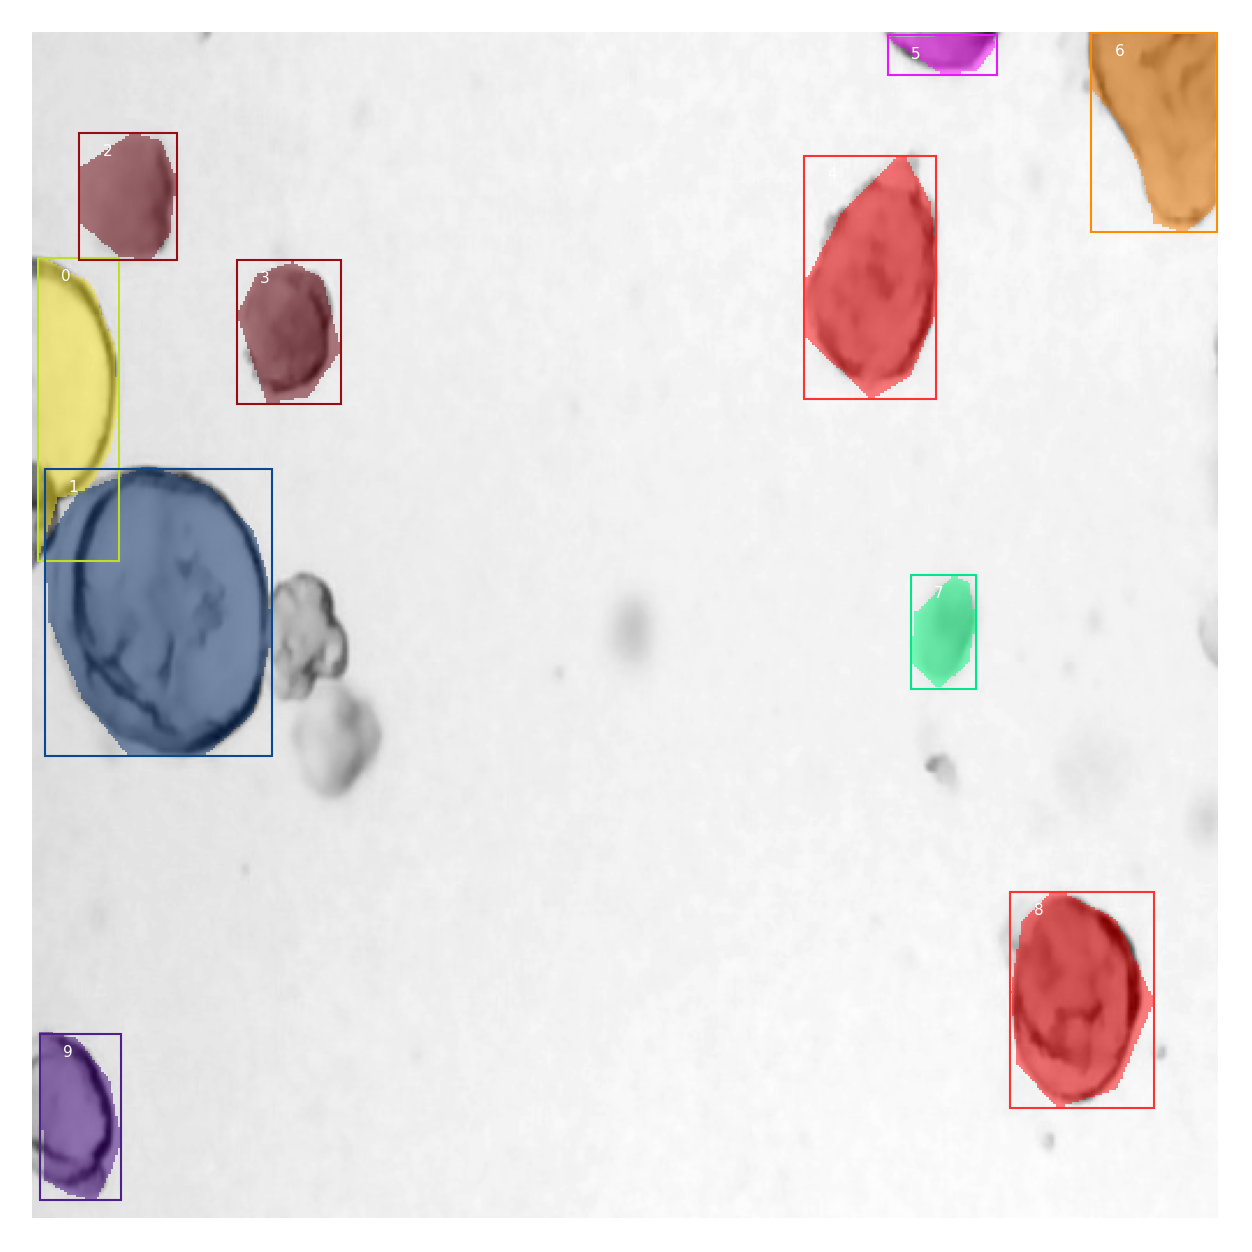

In [7]:
import random
import colorsys
from matplotlib import patches,  lines
import os
import sys
import random
import itertools
import colorsys

import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import matplotlib.cm as cm
import cv2

list_of_colormaps = [
    'viridis','Purples', 'Blues','Reds','winter', 'cool','Wistia', 'copper','bwr'
]


n = random.randint(0,len(dataset_train.image_ids))

print('Showing training image ID: ' + str(n))
# load the image
image = dataset_train.load_image(n)
print(image.shape)
info = dataset_train.image_info[n]

# load the masks and the class ids
mask, class_ids = dataset_train.load_mask(n)

bbox = extract_bboxes(mask)
# # display image with masks and bounding boxes
display_instances(image, bbox, mask,positions = None, class_ids = class_ids, class_names =  dataset_train.class_names)

#confirmed everything works okay - proceed to training


In [8]:
def find_dimaeters(bb):
    x_diameter = bb[3]-bb[1]
    y_diameter = bb[2]-bb[0]
    return(x_diameter,y_diameter)

def scale_to_512(image_size,diameters):
    multiplier = 512/image_size
    x_diameter = diameters[0]*multiplier
    y_diameter = diameters[1]*multiplier
    return(int(x_diameter),int(y_diameter))

diameters = []

for n in range(len(dataset_train.image_ids)):
    image_size = dataset_train.load_image(n).shape[0]
    # load the masks and the class ids
    mask, class_ids = dataset_train.load_mask(n)

    bbox = extract_bboxes(mask)
    for i,bb in enumerate(bbox):
        found_diameters = scale_to_512(image_size,find_dimaeters(bb))
        diameters.append({'Image_ID' : n,
                          'organoid_id' : i,
                          'diameter_orientation': 'x',
                          'diameter' : found_diameters[0]})
        
        diameters.append({'Image_ID' : n,
                          'organoid_id' : i,
                          'diameter_orientation': 'y',
                          'diameter' : found_diameters[1]})


20 32.0 69.0 124.5 400


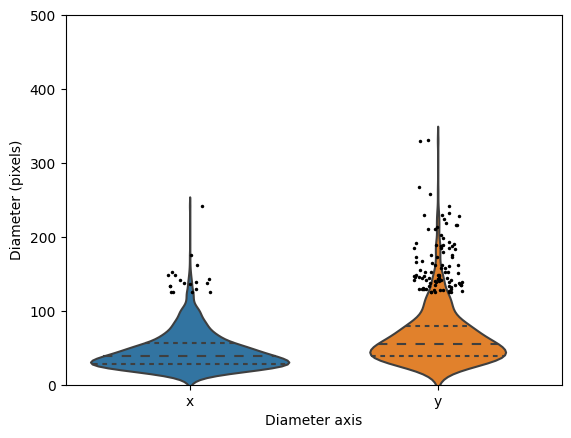

In [9]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(diameters)

# drop datapoints with 0 which may skew that visualisation and just represent empty labels
df = df[df.diameter != 0]

# drop labels with diameter greater than 500 since these are likely to be mislabelled organoids
df = df[df.diameter < 500]

q1, q3 = np.percentile(df.diameter, [25, 75])
whisker_low = q1 - (q3 - q1) * 1.5
whisker_high = q3 + (q3 - q1) * 1.5
outliers = df[(df.diameter > whisker_high) | (df.diameter < whisker_low)]
outliers.replace('x', 0)
outliers.replace('y', 1)



sns.violinplot(df, y="diameter", x = "diameter_orientation", orient = 'v',inner="quartile",
    notch=False, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"}).set(
    ylabel='Diameter (pixels)', 
    xlabel='Diameter axis'
)
sns.stripplot(outliers,x='diameter_orientation', y='diameter', marker='.', color='black', size = 5)
plt.ylim(0, 500)

print(20,q1,q3,whisker_high,400)

In [12]:
# define a configuration for the model
from keras import backend as K 
K.clear_session()
class irregularConfig(Config):
	# define the name of the configuration
	NAME = "irregularConfig"
	# number of classes (background + irreg_organoid)
	NUM_CLASSES = 1 + 1
	# number of training steps per epoch
	STEPS_PER_EPOCH = len(dataset_train.image_ids)
	VALIDATION_STEPS = len(dataset_val.image_ids)
	IMAGES_PER_GPU  = 1
# Don't exclude based on confidence. Since we have two classes
# then 0.5 is the minimum anyway as it picks between nucleus and BG
	DETECTION_MIN_CONFIDENCE = 0.8
	DETECTION_NMS_THRESHOLD = 0.5       
	WEIGHT_DECAY = 0.001
	TRAIN_ROIS_PER_IMAGE = 600
	MAX_GT_INSTANCES = 50
	IMAGE_MIN_DIM = 512
	IMAGE_MAX_DIM = 512
	IMAGE_MIN_SCALE = 2.0
	LEARNING_RATE = 0.0001
	IMAGE_CHANNEL_COUNT = 1
	MEAN_PIXEL = int(overall_mean_pixel_value)
	USE_MINI_MASK=True
	IMAGE_RESIZE_MODE ='crop'
# Length of square anchor side in pixels
	RPN_ANCHOR_SCALES = (20,int(q1),int(q3),int(whisker_high),400)
	RPN_NMS_THRESHOLD = 0.9
	RPN_TRAIN_ANCHORS_PER_IMAGE = 512
	RPN_ANCHOR_STRIDE = 1 
	RPN_ANCHOR_RATIOS = [0.5,1,2]         
# prepare config
config = irregularConfig()
config.display() 




Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.5
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [512 512   1]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

Using TensorFlow backend.


C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


mask                     shape: (56, 56, 5)           min:    0.00000  max:    1.00000  bool


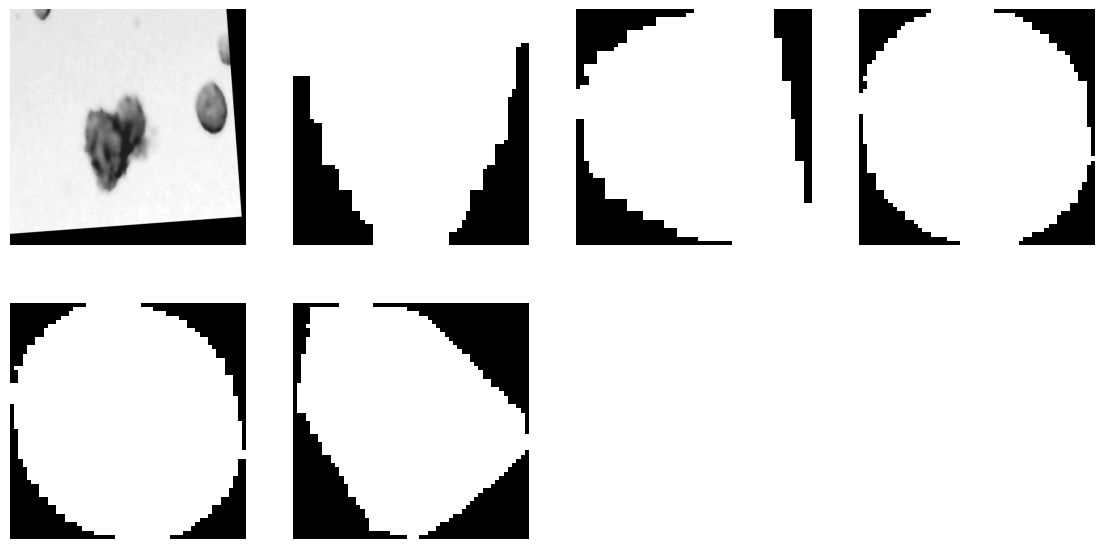

In [13]:
# visualize effect of augmentation
def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interpolation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.show()



import imgaug.augmenters as iaa
n = random.randint(1, 157)

# augmentation = iaa.SomeOf((0, 2), [
#     iaa.Fliplr(0.5),
#     iaa.Flipud(0.5),
#     iaa.OneOf([iaa.Affine(rotate=90),
#                iaa.Affine(rotate=180),
#                iaa.Affine(rotate=270)]),
#     iaa.Multiply((0.8, 1.5)),
#     iaa.GaussianBlur(sigma=(0.0, 5.0))
# ])

augmentation = iaa.Sequential([
            iaa.Fliplr(0.5), # horizontal flips
            # Small gaussian blur with random sigma between 0 and 0.5.
            # But we only blur about 50% of all images.
            iaa.Sometimes(0.5,
                iaa.GaussianBlur(sigma=(0, 0.5))
            ),
            # Strengthen or weaken the contrast in each image.
            iaa.ContrastNormalization((0.75, 1.5)),
            # Apply affine transformations to each image.
            # Scale/zoom them, translate/move them, rotate them and shear them.
            iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                rotate=(-10, 10),
                shear=(-1, 1))
            ], random_order=True) # apply augmenters in random order


import mrcnn.model as modellib
from mrcnn.model import log
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset_train, config, n, augmentation=augmentation, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(0,mask.shape[2])], cmap ='gray')

In [14]:
from keras.callbacks import ModelCheckpoint
from mrcnn.model import MaskRCNN
ROOT_DIR = os.getcwd()
os.chdir(ROOT_DIR)
DEFAULT_LOGS_DIR = r'E:\mask_rcnn\irregular_images'
COCO_WEIGHTS_PATH =  r'E:\mask_rcnn\mask_rcnn_coco.h5'

model = MaskRCNN(mode='training', model_dir=DEFAULT_LOGS_DIR, config=config)
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask","conv1"])
#model.log_dir = DEFAULT_LOGS_DIR
# train model on loaded weights on dataset of labelled organoids
print("Train all layers at 0.0005 LR")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=25,
            augmentation=augmentation,
            layers='all')

Train all layers at 0.0005 LR

Starting at epoch 0. LR=0.0001

Checkpoint Path: E:\mask_rcnn\mask_rcnn_irregularconfig_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a

C:\Anaconda\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Anaconda\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Anaconda\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/25
156/156 [==============================] - 295s 2s/step - loss: 2.8106 - val_loss: 2.2362
Epoch 2/25
156/156 [==============================] - 262s 2s/step - loss: 1.9500 - val_loss: 4.5959
Epoch 3/25
156/156 [==============================] - 259s 2s/step - loss: 1.3697 - val_loss: 0.9701
Epoch 4/25
156/156 [==============================] - 260s 2s/step - loss: 1.2375 - val_loss: 0.7413
Epoch 5/25
156/156 [==============================] - 256s 2s/step - loss: 1.0873 - val_loss: 1.9174
Epoch 6/25
156/156 [==============================] - 256s 2s/step - loss: 1.1323 - val_loss: 0.5279
Epoch 7/25
156/156 [==============================] - 252s 2s/step - loss: 1.0125 - val_loss: 0.3697
Epoch 8/25
156/156 [==============================] - 254s 2s/step - loss: 0.9275 - val_loss: 0.9773
Epoch 9/25
156/156 [==============================] - 258s 2s/step - loss: 0.8990 - val_loss: 0.9471
Epoch 10/25
156/156 [==============================] - 257s 2s/step - loss: 0.8505 - val_lo

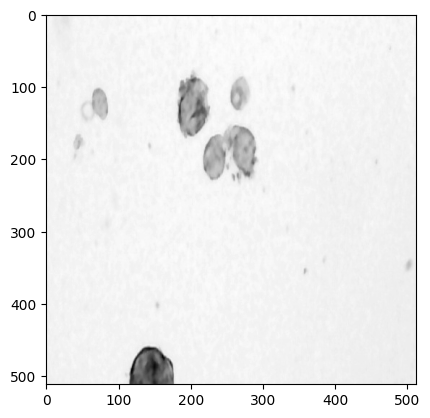

In [49]:
# mAP calculation
import cv2
import time
from IPython.display import clear_output
from mrcnn import utils
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib import patches,  lines
import matplotlib.cm as cm
from matplotlib.patches import Polygon, Rectangle
from mrcnn.model import MaskRCNN
import os
import sys
import random
import itertools
import colorsys
import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
import time
import itertools
from datetime import timedelta
import pandas as pd
from keras import backend as K 



#define start time of code
ROOT_DIR = os.getcwd()
os.chdir(ROOT_DIR)
DEFAULT_LOGS_DIR = r'C:\Users\Standard User'
COCO_WEIGHTS_PATH =  r'C:\Users\Standard User\mask_rcnn_coco.h5'

confidences = []
TP_rate = []
FP_rate = []
dice_score_at_confidence = []
mean_IOUs_at_confidence = []


#define class with the images per batch
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "spherical_cfg"
    # number of classes (background + Blue Marbles + Non Blue marbles)
    NUM_CLASSES = 1 + 1
    # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    # find the largest divisible number that is less than the max number of images possible per GPU
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.8
    IMAGE_CHANNEL_COUNT = 1
    MEAN_PIXEL = mean(125)
    USE_MINI_MASK=False
    IMAGE_RESIZE_MODE ='crop'
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_NMS_THRESHOLD = 0.3
    RPN_ANCHOR_SCALES = (20,q1,q3,whisker_high,400)
    #RPN_ANCHOR_SCALES = (20,80,160,320,480)
    #RPN_ANCHOR_SCALES = (32, 64, 128,256,512)
    RPN_TRAIN_ANCHORS_PER_IMAGE = 600
    RPN_ANCHOR_STRIDE = 1 
    RPN_ANCHOR_RATIOS = [0.5,1,2]        

# create config
cfg = PredictionConfig()
#cfg.display()

# define the model
model = MaskRCNN(mode='inference', model_dir=DEFAULT_LOGS_DIR, config=cfg)
# load model weights
model.load_weights(r'E:\mask_rcnn\mask_rcnn_irregularconfig_0025.h5', by_name=True)

def resize_mask(mask):
    #round to multiple of 256
    width = image.shape[1]
    height = image.shape[0]

    def myround(x, base=512):
        if x < 512:
            return 512
        else:
            return base * math.floor(x/base)
    width = myround(width)
    height = myround(height)
    mask = cv2.resize(mask, (width,height), interpolation = cv2.INTER_AREA)
    return mask

def compute_overlaps_masks(masks1, masks2):

    #ensure masks are thee same size
    if masks1.shape[0:2] != (512,512):
        masks1 = np.dstack([resize_mask(masks1[:,:,i]) for i in range(masks1.shape[-1])])
    if masks2.shape[0:2] != (512,512):
        masks2 = np.dstack([resize_mask(masks2[:,:,i]) for i in range(masks2.shape[-1])])

    # If either set of masks is empty return empty result
    if masks1.shape[-1] == 0 or masks2.shape[-1] == 0:
        return np.zeros((masks1.shape[-1], masks2.shape[-1]))
    # flatten masks and compute their areas
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)

    # intersections and union
    intersections = np.dot(masks1.T, masks2)
    union = area1[:, None] + area2[None, :] - intersections
    overlaps = intersections / union
    return overlaps


def trim_zeros(x):

    assert len(x.shape) == 2
    return x[~np.all(x == 0, axis=1)]

def compute_matches(gt_boxes, gt_class_ids, gt_masks,
                    pred_boxes, pred_class_ids, pred_scores, pred_masks,
                    iou_threshold=0.5, score_threshold=0.0):

    # Trim zero padding
    # TODO: cleaner to do zero unpadding upstream
    gt_boxes = trim_zeros(gt_boxes)
    gt_masks = gt_masks[..., :gt_boxes.shape[0]]
    pred_boxes = trim_zeros(pred_boxes)
    pred_scores = pred_scores[:pred_boxes.shape[0]]
    # Sort predictions by score from high to low
    indices = np.argsort(pred_scores)[::-1]
    pred_boxes = pred_boxes[indices]
    pred_class_ids = pred_class_ids[indices]
    pred_scores = pred_scores[indices]
    pred_masks = pred_masks[..., indices]

    # Compute IoU overlaps [pred_masks, gt_masks]
    overlaps = compute_overlaps_masks(pred_masks, gt_masks)

    # Loop through predictions and find matching ground truth boxes
    match_count = 0
    pred_match = -1 * np.ones([pred_boxes.shape[0]])
    gt_match = -1 * np.ones([gt_boxes.shape[0]])
    for i in range(len(pred_boxes)):
        # Find best matching ground truth box
        # 1. Sort matches by score
        sorted_ixs = np.argsort(overlaps[i])[::-1]
        # 2. Remove low scores
        low_score_idx = np.where(overlaps[i, sorted_ixs] < score_threshold)[0]
        if low_score_idx.size > 0:
            sorted_ixs = sorted_ixs[:low_score_idx[0]]
        # 3. Find the match
        for j in sorted_ixs:
            # If ground truth box is already matched, go to next one
            if gt_match[j] > -1:
                continue
            # If we reach IoU smaller than the threshold, end the loop
            iou = overlaps[i, j]
            if iou < iou_threshold:
                break
            # Do we have a match?
            if pred_class_ids[i] == gt_class_ids[j]:
                match_count += 1
                gt_match[j] = i
                pred_match[i] = j
                break

    return match_count, gt_match, pred_match, overlaps



mean_IOUs = []
TPs = []
FPs = []
dice_scores = []
mAPs = []

for n in range(len(dataset_val.image_ids)):

    image = dataset_val.load_image(n)
    # load the masks and the bboxes
    gt_mask, gt_class_ids = dataset_val.load_mask(n)
    gt_bbox = extract_bboxes(gt_mask)

    #round to multiple of 256
    width = image.shape[1]
    height = image.shape[0]

    def myround(x, base=512):
        if x < 512:
            return 512
        else:
            return base * math.floor(x/base)
    width = myround(width)
    height = myround(height)
    resized = cv2.resize(image, (width,height), interpolation = cv2.INTER_AREA)
    resized_plot = np.expand_dims(resized,axis=-1)
    resized = np.expand_dims(resized_plot,axis=0)
    #define class with the images per batch

    detected = model.detect(resized)[0]
    pred_bboxes =detected['rois']
    pred_masks = detected['masks']
    pred_class_ids = detected['class_ids']
    pred_scores = detected['scores']


    matches, gt_matches, pred_matches, overlaps = compute_matches(gt_bbox, gt_class_ids, gt_mask,
                        pred_bboxes, pred_class_ids, pred_scores, pred_masks,
                        iou_threshold=0.5, score_threshold=0.5)

    # Compute precision and recall at each prediction box step
    precisions = np.cumsum(pred_matches > -1) / (np.arange(len(pred_matches)) + 1)

    recalls = np.cumsum(pred_matches > -1).astype(np.float32) / len(gt_matches)

    #    # Pad with start and end values to simplify the math
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    # Ensure precision values decrease but don't increase. This way, the
    # precision value at each recall threshold is the maximum it can be
    # for all following recall thresholds, as specified by the VOC paper.
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    # Compute mean AP over recall range
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) * precisions[indices])
    positions = [(0,0)]*len(pred_class_ids)

    mAPs.append(mAP)

print(mean(mAPs))

0.8064878206279772


In [54]:
# ROC curve generation
import cv2
import time
from IPython.display import clear_output
from mrcnn import utils
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib import patches,  lines
import matplotlib.cm as cm
from matplotlib.patches import Polygon, Rectangle
from mrcnn.model import MaskRCNN
import os
import sys
import random
import itertools
import colorsys
import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
import time
import itertools
from datetime import timedelta
import pandas as pd
from keras import backend as K 


#define start time of code
ROOT_DIR = os.getcwd()
os.chdir(ROOT_DIR)
DEFAULT_LOGS_DIR = r'C:\Users\Standard User'
COCO_WEIGHTS_PATH =  r'C:\Users\Standard User\mask_rcnn_coco.h5'

confidences = []
TP_rate = []
FP_rate = []
dice_score_at_confidence = []
mean_IOUs_at_confidence = []


def resize_mask(mask):
    #round to multiple of 256
    width = image.shape[1]
    height = image.shape[0]

    def myround(x, base=512):
        if x < 512:
            return 512
        else:
            return base * math.floor(x/base)
    width = myround(width)
    height = myround(height)
    mask = cv2.resize(mask, (width,height), interpolation = cv2.INTER_AREA)
    return mask

def compute_overlaps_masks(masks1, masks2):
    """Computes IoU overlaps between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    """

    #ensure masks are thee same size
    if masks1.shape[0:2] != (512,512):
        masks1 = np.dstack([resize_mask(masks1[:,:,i]) for i in range(masks1.shape[-1])])
    if masks2.shape[0:2] != (512,512):
        masks2 = np.dstack([resize_mask(masks2[:,:,i]) for i in range(masks2.shape[-1])])

    # If either set of masks is empty return empty result
    if masks1.shape[-1] == 0 or masks2.shape[-1] == 0:
        return np.zeros((masks1.shape[-1], masks2.shape[-1]))
    # flatten masks and compute their areas
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)

    # intersections and union
    intersections = np.dot(masks1.T, masks2)
    union = area1[:, None] + area2[None, :] - intersections
    overlaps = intersections / union
    return overlaps


def trim_zeros(x):
    """It's common to have tensors larger than the available data and
    pad with zeros. This function removes rows that are all zeros.

    x: [rows, columns].
    """
    assert len(x.shape) == 2
    return x[~np.all(x == 0, axis=1)]

def compute_matches(gt_boxes, gt_class_ids, gt_masks,
                    pred_boxes, pred_class_ids, pred_scores, pred_masks,
                    iou_threshold=0.5, score_threshold=0.0):
    """Finds matches between prediction and ground truth instances.

    Returns:
        gt_match: 1-D array. For each GT box it has the index of the matched
                  predicted box.
        pred_match: 1-D array. For each predicted box, it has the index of
                    the matched ground truth box.
        overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Trim zero padding
    # TODO: cleaner to do zero unpadding upstream
    gt_boxes = trim_zeros(gt_boxes)
    gt_masks = gt_masks[..., :gt_boxes.shape[0]]
    pred_boxes = trim_zeros(pred_boxes)
    pred_scores = pred_scores[:pred_boxes.shape[0]]
    # Sort predictions by score from high to low
    indices = np.argsort(pred_scores)[::-1]
    pred_boxes = pred_boxes[indices]
    pred_class_ids = pred_class_ids[indices]
    pred_scores = pred_scores[indices]
    pred_masks = pred_masks[..., indices]

    # Compute IoU overlaps [pred_masks, gt_masks]
    overlaps = compute_overlaps_masks(pred_masks, gt_masks)

    # Loop through predictions and find matching ground truth boxes
    match_count = 0
    pred_match = -1 * np.ones([pred_boxes.shape[0]])
    gt_match = -1 * np.ones([gt_boxes.shape[0]])
    for i in range(len(pred_boxes)):
        # Find best matching ground truth box
        # 1. Sort matches by score
        sorted_ixs = np.argsort(overlaps[i])[::-1]
        # 2. Remove low scores
        low_score_idx = np.where(overlaps[i, sorted_ixs] < score_threshold)[0]
        if low_score_idx.size > 0:
            sorted_ixs = sorted_ixs[:low_score_idx[0]]
        # 3. Find the match
        for j in sorted_ixs:
            # If ground truth box is already matched, go to next one
            if gt_match[j] > -1:
                continue
            # If we reach IoU smaller than the threshold, end the loop
            iou = overlaps[i, j]
            if iou < iou_threshold:
                break
            # Do we have a match?
            if pred_class_ids[i] == gt_class_ids[j]:
                match_count += 1
                gt_match[j] = i
                pred_match[i] = j
                break

    return match_count, gt_match, pred_match, overlaps
    
    

for roundd,confidence in enumerate(np.linspace(0,1,50)):
    K.clear_session()
    confidences.append(confidence)
    clear_output(wait=True)
    print('Performing: ',  str(roundd+1))
    
    #define class with the images per batch
    class PredictionConfig(Config):
        # define the name of the configuration
        NAME = "spherical_cfg"
        # number of classes (background + Blue Marbles + Non Blue marbles)
        NUM_CLASSES = 1 + 1
        # Set batch size to 1 since we'll be running inference on
                # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
        GPU_COUNT = 1
        # find the largest divisible number that is less than the max number of images possible per GPU
        IMAGES_PER_GPU = 1
        DETECTION_MIN_CONFIDENCE = confidence
        IMAGE_CHANNEL_COUNT = 1
        MEAN_PIXEL = mean(125)
        USE_MINI_MASK=False
        IMAGE_RESIZE_MODE ='crop'
        IMAGE_MIN_DIM = 512
        IMAGE_MAX_DIM = 512
        DETECTION_NMS_THRESHOLD = 0.3
        RPN_ANCHOR_SCALES = (20,q1,q3,whisker_high,400)
        #RPN_ANCHOR_SCALES = (20,80,160,320,480)
        #RPN_ANCHOR_SCALES = (32, 64, 128,256,512)
        RPN_TRAIN_ANCHORS_PER_IMAGE = 600
        RPN_ANCHOR_STRIDE = 1 
        RPN_ANCHOR_RATIOS = [0.5,1,2]            


    # create config
    cfg = PredictionConfig()
    #cfg.display()

    # define the model
    model = MaskRCNN(mode='inference', model_dir=DEFAULT_LOGS_DIR, config=cfg)
    # load model weights
    model.load_weights(r'E:\mask_rcnn\mask_rcnn_irregularConfig_0025.h5', by_name=True)


    mean_IOUs = []
    TPs = []
    FPs = []
    dice_scores = []

    for n in range(len(dataset_val.image_ids)):

        image = dataset_val.load_image(n)
        # load the masks and the bboxes
        gt_mask, gt_class_ids = dataset_val.load_mask(n)
        gt_bbox = extract_bboxes(gt_mask)

        #round to multiple of 256
        width = image.shape[1]
        height = image.shape[0]

        def myround(x, base=512):
            if x < 512:
                return 512
            else:
                return base * math.floor(x/base)
        width = myround(width)
        height = myround(height)
        resized = cv2.resize(image, (width,height), interpolation = cv2.INTER_AREA)
        resized = np.expand_dims(resized,axis=-1)
        resized = np.expand_dims(resized,axis=0)
        #define class with the images per batch

        detected = model.detect(resized)[0]
        pred_bboxes =detected['rois']
        pred_masks = detected['masks']
        pred_class_ids = detected['class_ids']
        pred_scores = detected['scores']


        matches, gt_indexes, pred_indexes, IoU_values = compute_matches(gt_bbox, gt_class_ids, gt_mask,
                            pred_bboxes, pred_class_ids, pred_scores, pred_masks,
                            iou_threshold=0.5, score_threshold=0.5)

        IoUs = np.amax(IoU_values, axis=1)
        mean_IoU = IoUs[IoUs !=0].mean()
        mean_IOUs.append(mean_IoU)

        TP = matches
        TPs.append(TP/gt_mask.shape[-1])
        FP = pred_masks.shape[-1]-matches
        FPs.append(FP/gt_mask.shape[-1])

        #compute_dice
        dice = (2*TP)/((2*TP)+FP+((gt_mask.shape[-1])-(pred_masks.shape[-1])))
        dice_scores.append(dice)
    TP_rate.append(mean(TPs))
    FP_rate.append(mean(FPs))
    dice_score_at_confidence.append(mean(dice_scores))
    mean_IOUs_at_confidence.append(mean(mean_IOUs))



Performing:  50


C:\Anaconda\envs\maskrcnn\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "width" which is no longer supported as of 3.3 and will become an error in 3.6
C:\Anaconda\envs\maskrcnn\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "height" which is no longer supported as of 3.3 and will become an error in 3.6


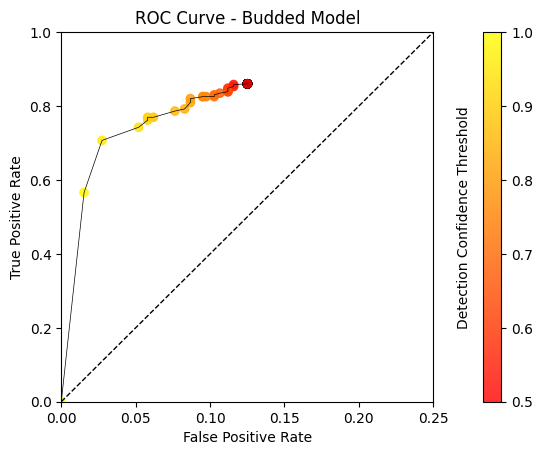

In [65]:
PR_df = pd.DataFrame(
    {'TP': TP_rate,
     'FP': FP_rate,
     'confidence': confidences,
     'IOU':mean_IOUs_at_confidence,
     'dice':dice_score_at_confidence
    })

plt.scatter(PR_df.FP, PR_df.TP, alpha = .8, c = PR_df.confidence, cmap = 'autumn')
plt.plot(PR_df.FP, PR_df.TP,c = 'black',linewidth=0.5)
plt.axline( (0,0),slope=4,linestyle='--',color='black', linewidth = 1)
plt.ylim(0,1)
plt.xlim(0,0.25)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Budded Model')
cbar = plt.colorbar(pad = 0.1)
cbar.set_label('Detection Confidence Threshold',labelpad=-55)
plt.clim(0.5,1)

plt.savefig(r'E:\mask_rcnn\budded_ROC_curve_epoch_25.png', dpi = 1200, width = 8, height = 6)

In [64]:
from sklearn.metrics import auc
max_FP = PR_df['FP'].max()
ratio = 1/max_FP
auc(PR_df['FP'],PR_df['TP'])*ratio

7.9951980792316935


0.7113673317862135

In [66]:
PR_df['thres'] = PR_df['TP'] - (1-PR_df['FP'])
PR_df

,TP,FP,confidence,IOU,dice,thres
0,0.860059,0.125075,0.000000,0.807183,0.916185,-0.014866
1,0.860059,0.125075,0.020408,0.807183,0.916185,-0.014866
2,0.860059,0.125075,0.040816,0.807183,0.916185,-0.014866
3,0.860059,0.125075,0.061224,0.807183,0.916185,-0.014866
4,0.860059,0.125075,0.081633,0.807183,0.916185,-0.014866
5,0.860059,0.125075,0.102041,0.807183,0.916185,-0.014866
6,0.860059,0.125075,0.122449,0.807183,0.916185,-0.014866
7,0.860059,0.125075,0.142857,0.807183,0.916185,-0.014866
8,0.860059,0.125075,0.163265,0.807183,0.916185,-0.014866
9,0.860059,0.125075,0.183673,0.807183,0.916185,-0.014866


In [45]:
# test trained model 
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib.patches import Rectangle
from IPython.display import clear_output
from mrcnn.model import MaskRCNN

# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "spherical_cfg"
    # number of classes (background + irreg_organoid)
    NUM_CLASSES = 1 + 1
    IMAGES_PER_GPU  = 1
# Don't exclude based on confidence. Since we have two classes
# then 0.5 is the minimum anyway as it picks between nucleus and BG
    DETECTION_MIN_CONFIDENCE = 0.5
    DETECTION_NMS_THRESHOLD = 0.5
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_CHANNEL_COUNT = 1
    MEAN_PIXEL = int(overall_mean_pixel_value)
    USE_MINI_MASK=False
    IMAGE_RESIZE_MODE ='crop'
    RPN_ANCHOR_SCALES = (20, 80, 160,320,480)
    RPN_TRAIN_ANCHORS_PER_IMAGE = 600
    RPN_ANCHOR_STRIDE = 1 
    RPN_ANCHOR_RATIOS = [0.5,1,2]         

 
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for i,image_id in enumerate(dataset.image_ids):
		clear_output(wait=True)
		print('Evaluating ' + str(i + 1) + ' of ' + str(len(dataset.image_ids)))
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'], iou_threshold = 0.5)
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP
 

# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir=r'E:\mask_rcnn', config=cfg)
# load model weights
model.load_weights(r'E:\mask_rcnn\mask_rcnn_sphericalconfig_0025.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(dataset_val, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
# test_mAP = evaluate_model(dataset_train, model, cfg)
# print("Test mAP: %.3f" % test_mAP)

Evaluating 67 of 67
Train mAP: 0.770


7


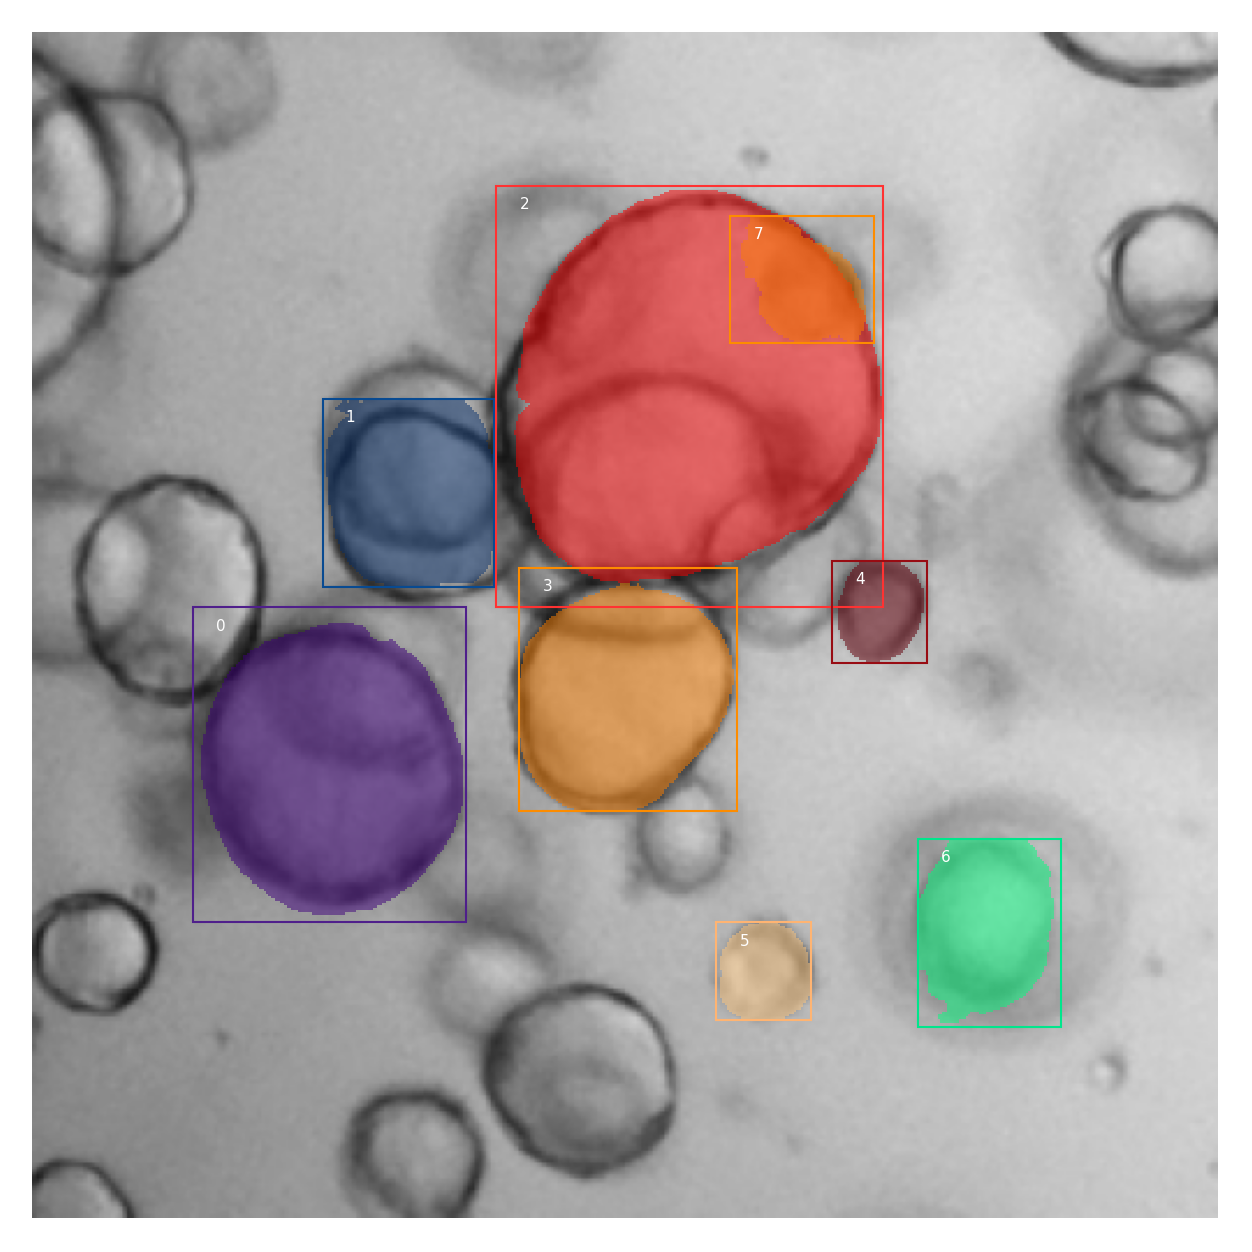

5.320225238800049


In [12]:
#modified inference pipeline

import cv2
import time
from IPython.display import clear_output
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib.patches import Rectangle
from mrcnn.model import MaskRCNN


start_time = time.time()

ROOT_DIR = os.getcwd()
os.chdir(ROOT_DIR)
DEFAULT_LOGS_DIR = r'C:\Users\Standard User'
COCO_WEIGHTS_PATH =  r'C:\Users\Standard User\mask_rcnn_coco.h5'


#marbles_img = skimage.io.imread(r"E:\Organoid_Images\OrganoidKillingAssays\Organoid T cell killing assay\OKA_2\Stitch_output\stitched_Day1_S_PBMCs_4B1.tif")
marbles_img = cv2.imread(r"E:\mask_rcnn\spherical_images\val\Subset_1_300x300_208.jpg",cv2.IMREAD_GRAYSCALE)
#marbles_img = skimage.io.imread(r"E:\Organoid_Images\Steph\Cell Counts\SBWCRC033\Round 2\EVOS\Tiles\Tumour Well 3 Tile.tif")


if len(marbles_img.shape) > 3:
    marbles_img = marbles_img.squeeze()

# if marbles_img.shape[0] > 1 :
#     marbles_img = marbles_img[0,:,:,:]

#marbles_img = cv2.resize(marbles_img, (int(marbles_img.shape[0]/1.1),int(marbles_img.shape[1]/1.1)), interpolation = cv2.INTER_AREA)    
    
n=512
#round to multiple of 256
width = marbles_img.shape[1]
height = marbles_img.shape[0]

def myround(x, base=n):
    if x < n:
        return 512
    else:
        return base * math.floor(x/base)
width = myround(width)
height = myround(height)
resized = cv2.resize(marbles_img, (width,height), interpolation = cv2.INTER_AREA)


if len(resized.shape) < 3:
    # maskRCNN doesnt work with grayscale images so convert to color
    resized = cv2.cvtColor(resized,cv2.COLOR_GRAY2RGB)
    
# generate position ids
height_coords = list(range(0, height, 256))
width_coords = list(range(0, width, 256))
coords_list = [(i,j) for i in height_coords for j in width_coords] 

# generate 4d array composed of 512x512 image patches of resuzed
n = 512
patchez = [resized[i:i+n, j:j+n] for i,j in coords_list]
# drop those patches that contain 256 in the size
patchez = [x for x in patchez if 256 not in (x.shape)]
# drop those patches that contain 0 in the size
patchez = [x for x in patchez if 0 not in (x.shape)]

image_patches = np.stack(patchez, axis = 0)
number_of_images = image_patches.shape[0]

# filter coordinate_list to match the above patches
coords_list = [x for x in coords_list if width - x[1] != 256]
coords_list = [x for x in coords_list if height - x[0] != 256]

images_per_batch = max([x for x in range(1,number_of_images+1) if not number_of_images%x and x <=5])
print('Images per batch: ' + str(images_per_batch))
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "irregularConfig"
    # number of classes (background + Blue Marbles + Non Blue marbles)
    NUM_CLASSES = 1 + 1
    # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    # find the largest divisible number that is less than the max number of images possible per GPU

    IMAGES_PER_GPU = images_per_batch
    BATCH_SIZE = images_per_batch
    DETECTION_MIN_CONFIDENCE = 0.9

# create config
cfg = PredictionConfig()

# define the model
model = MaskRCNN(mode='inference', model_dir=DEFAULT_LOGS_DIR, config=cfg)
# load model weights
model.load_weights(r'E:\mask_rcnn\mask_rcnn_sphericalConfig_0050.h5', by_name=True, exclude = ['conv1'])


import time

start_time = time.time()
itr = int(number_of_images/images_per_batch)

patch_num=1
positions = []
rois_list = []
masks = []
class_ids = []
scores = []

patch_num=1
positions = []
rois_list = []
masks = []
class_ids = []
scores = []

def append_coords(l):
    l[0] += x
    l[1] += y
    l[2] += x
    l[3] += y
    return l

h_xmin = 40
h_xmax = 472
h_ymin = 40
h_ymax = 472



outputs = []
for i in range(0,itr):
    clear_output(wait=True)
    print(i)
    print(image_patches[int((i*images_per_batch)):int((i*images_per_batch)+images_per_batch), :, :, :].shape)
    detected = model.detect(image_patches[int((i*images_per_batch)):int((i*images_per_batch)+images_per_batch), :, :, :])
    class_names = ['BG', 'irregular_organiod']
    for j in range(0,images_per_batch):
        results = detected[j]
        bbox_status = []
        for a, rois in enumerate(results['rois']):
            bbox_corners = [
            (rois[0], rois[1]),
            (rois[2], rois[3]),
            (rois[2], rois[1]),
            (rois[0], rois[3])]

            corner_values = []
            for corner in bbox_corners:
                in_range_along_x = corner[0] < h_xmax and corner[0] > h_xmin
                in_range_along_y = corner[1] < h_ymax and corner[1] > h_ymin
                if in_range_along_x and in_range_along_y:
                    corner_values.append(1)
                else:
                     corner_values.append(0)
            if 0 in corner_values:
                bbox_status.append('Touching')
            else:
                bbox_status.append('None_touching')

        indicies_to_delete = [i for i, x in enumerate(bbox_status) if x == "Touching"]
        # generate updated indicies
        list_to_subtract = list(range(0, len(indicies_to_delete)))
        indicies_to_delete = [a_i - b_i for a_i, b_i in zip(indicies_to_delete, list_to_subtract)]

        #delete all mask information for masks touching borders
        for index in indicies_to_delete:
            results['rois'] = np.delete(results['rois'], index, 0)
            results['class_ids'] = np.delete(results['class_ids'], index, 0)
            results['scores'] = np.delete(results['scores'], index, 0)
            results['masks'] = np.delete(results['masks'], index, 2)

        x,y = coords_list[(i*images_per_batch) + j]
        rois_list.append( list(map(append_coords, results['rois']))  )
        masks.append(results['masks'])
        class_ids.append(results['class_ids'])
        scores.append(results['scores'])
        number_of_instances = len(results['rois'])
        positions.append([[x,y]] * number_of_instances)


rois_flattened = np.array([item for sublist in rois_list for item in sublist])
masks_flattened = np.dstack(masks)
class_ids_flattened = np.array([item for sublist in class_ids for item in sublist])
scores_flattened = np.array([item for sublist in scores for item in sublist])
positions_flattened = np.array([item for sublist in positions for item in sublist])


import itertools

def checkoverlap(box1,box2):
    box1_left, box1_top, box1_bottom,box1_right = box1
    box2_left, box2_top, box2_bottom,box2_right = box2
    
    #check if box2 in box1
    if box1_left >= box2_left or box1_right <= box2_right and box1_top >= box2_top or box1_bottom <= box2_bottom:
        return True
    if box1_left <= box2_left or box1_right >= box2_right and box1_top <= box2_top or box1_bottom >= box2_bottom:
        return True
    else:
        return False
    

def findsize(rois):
    width = rois[3] - rois[1]
    height = rois[2] - rois[0]
    return width,height

def compare_rois(rois1, rois2):
    if checkoverlap(rois1, rois2):
        #if true find the bigger one
        size_box1 = findsize(rois1)
        size_box2 = findsize(rois2)
        if size_box1 > size_box2:
            return rois1, rois2
        else:
            return rois2, rois1
    else:
        print('Not overlapping')

def find_index(arr, x):
    return np.where((arr == x).all(axis=1))[0]

from IPython.display import clear_output
print('Calculating overlap')
overlapping_indicies = []
pixel_range = 50
for i,rois in enumerate(rois_flattened):
    clear_output(wait=True)
    print('Performing ', str(i))
    x1,y1 = rois[0],rois[1]
    x2,y2 = rois[2],rois[3]
    points = ([x1,y1], [x2,y2])
    for point in points:
        range_points_1 = ([point[0]-pixel_range, point[1]-pixel_range, point[0]+pixel_range, point[1]+pixel_range])
        rois_of_interest = [x for x in rois_flattened if range_points_1[0] <= x[0] <= range_points_1[2] and range_points_1[1] <= x[1] <= range_points_1[3]]
        if len(rois_of_interest) > 1:
            combinations_of_rois = list(itertools.combinations(rois_of_interest, 2))
            for combination in combinations_of_rois:
                largest_rois,smallest_rois = compare_rois(combination[0],combination[1])

                #index of smallest rois
                index_of_smallest = find_index(rois_flattened, smallest_rois)[0]
                overlapping_indicies.append(index_of_smallest)

                
print(len(overlapping_indicies))
for index in overlapping_indicies:
    rois_flattened[index] = 0
    masks_flattened[:,:,index] = 0
    class_ids_flattened[index] = 0
    scores_flattened[index] = 0
    positions_flattened[index] = 777

rois_flattened = np.array([x for x in rois_flattened if x.all() != 0 ])
masks_flattened = np.dstack([masks_flattened[:,:,i] for i in range(masks_flattened.shape[2]) if masks_flattened[:,:,i].any() == True])
class_ids_flattened = np.array([x for x in class_ids_flattened if x.all() != 0 ])
scores_flattened = np.array([x for x in scores_flattened if x.all() != 0 ])
positions_flattened = np.array([x for x in positions_flattened if x[0] != 777 ])


import os
import sys
import random
import itertools
import colorsys

import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import IPython.display

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils


############################################################
#  Visualization
############################################################

def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interpolation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.show()


def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, positions, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    # pad mask
    height = image.shape[0]
    width = image.shape[1]
    i = positions[0]
    j = positions[1]
    left = j
    right = width - left - n
    top = i
    bottom = height - top - n
    padded_mask = np.pad(mask, ((top, bottom), (left, right)))

    
    for c in range(3):
        image[:, :, c] = np.where(padded_mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def display_instances(image, boxes, masks, positions, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, show_captions= True, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    positions: [list of (i,j) coordinates dictating the patch that was analysed]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1.5,
                                alpha=1, linestyle="solid",
                                edgecolor=color, facecolor='None')
            ax.add_patch(p)

        # Label
        if show_captions:
            if not captions:
                class_id = class_ids[i]
                score = scores[i] if scores is not None else None
                label = class_names[class_id]
                caption = "{} {:.3f}".format(label, score) if score else label
            else:
                caption = captions[i]
            ax.text(x1, y1 + 8, caption,
                    color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, positions[i], color)

    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()
    #return(masked_image)
    

def checkoverlap(box1,box2):
    box1_left, box1_top, box1_bottom,box1_right = box1
    box2_left, box2_top, box2_bottom,box2_right = box2
    
    #check if box2 in box1
    if box1_left >= box2_left or box1_right <= box2_right and box1_top >= box2_top or box1_bottom <= box2_bottom:
        return True
    if box1_left <= box2_left or box1_right >= box2_right and box1_top <= box2_top or box1_bottom >= box2_bottom:
        return True
    else:
        return False
    

def findsize(rois):
    width = rois[3] - rois[1]
    height = rois[2] - rois[0]
    return width,height

def compare_rois(rois1, rois2):
    if checkoverlap(rois1, rois2):
        #if true find the bigger one
        size_box1 = findsize(rois1)
        size_box2 = findsize(rois2)
        if size_box1 > size_box2:
            return rois1, rois2
        else:
            return rois2, rois1
    else:
        print('Not overlapping')

def find_index(arr, x):
    return np.where((arr == x).all(axis=1))[0]


print('Calculating overlap')
overlapping_indicies = []
pixel_range = 50
for i,rois in enumerate(rois_flattened):
    clear_output(wait=True)
    print(i)
    x1,y1 = rois[0],rois[1]
    x2,y2 = rois[2],rois[3]
    points = ([x1,y1], [x2,y2])
    for point in points:
        range_points_1 = ([point[0]-pixel_range, point[1]-pixel_range, point[0]+pixel_range, point[1]+pixel_range])
        rois_of_interest = [x for x in rois_flattened if range_points_1[0] <= x[0] <= range_points_1[2] and range_points_1[1] <= x[1] <= range_points_1[3]]
        if len(rois_of_interest) > 1:
            combinations_of_rois = list(itertools.combinations(rois_of_interest, 2))
            for combination in combinations_of_rois:
                largest_rois,smallest_rois = compare_rois(combination[0],combination[1])

                #index of smallest rois
                index_of_smallest = find_index(rois_flattened, smallest_rois)[0]
                overlapping_indicies.append(index_of_smallest)


for index in overlapping_indicies:
    rois_flattened[index] = 0
    masks_flattened[:,:,index] = 0
    class_ids_flattened[index] = 0
    scores_flattened[index] = 0
    positions_flattened[index] = 777

rois_flattened = np.array([x for x in rois_flattened if x.all() != 0 ])
masks_flattened = np.dstack([masks_flattened[:,:,i] for i in range(masks_flattened.shape[2]) if masks_flattened[:,:,i].any() == True])
class_ids_flattened = np.array([x for x in class_ids_flattened if x.all() != 0 ])
scores_flattened = np.array([x for x in scores_flattened if x.all() != 0 ])
positions_flattened = np.array([x for x in positions_flattened if x[0] != 777 ])

import matplotlib.cm as cm


list_of_colormaps = [
    'viridis','Purples', 'Blues','Reds','winter', 'cool','Wistia', 'copper','bwr'
]

# modifying and more efficent mask plotting function

from matplotlib import patches,  lines
def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interpolation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.show()


def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors



def display_instances(image, boxes, masks, positions, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, show_captions= True, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    positions: [list of (i,j) coordinates dictating the patch that was analysed]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    #colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(image.astype(np.uint8))
    
    #masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        # generate colormap and color
        my_cmap = getattr(cm, random.choice(list_of_colormaps)).copy()
        my_cmap.set_under('k', alpha=0)
        color = my_cmap(0.9)

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1.5,
                                alpha=1, linestyle="solid",
                                edgecolor=color, facecolor='None')
            ax.add_patch(p)

        # Label
        if show_captions:
            ax.text(x1+10, y1 + 10, i,
                    color='w', size=11, backgroundcolor="none")

        # Mask
#         mask = masks[:, :, i]
#         if show_mask:
#             masked_image = apply_mask(masked_image, mask, positions[i], color)


        if show_mask:
            
            mask = masks[:,:,i]
            x = positions[i][0]
            y = positions[i][1]
            left = y
            right = width - left - n
            top = x
            bottom = height - top - n
            #print(top,bottom,left,right)
            plt.imshow(np.pad(mask, ((top, bottom), (left, right))), cmap=my_cmap, interpolation='none', clim=[0.9, 1], alpha = 0.5) 

        
    if auto_show:
        output_image = plt.show()
        
    return(output_image)
    

test_output = display_instances(resized,
                  boxes = rois_flattened, 
                  masks = masks_flattened, 
                  positions = positions_flattened,
                  class_ids = class_ids_flattened,
                  scores = scores_flattened,
                  class_names = dataset_train.class_names,
                  show_captions = True,
                  show_bbox = True,
                 show_mask = True)

print(time.time() - start_time)

In [57]:
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "irregularConfig"
    # number of classes (background + Blue Marbles + Non Blue marbles)
    NUM_CLASSES = 1 + 1
    # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    # find the largest divisible number that is less than the max number of images possible per GPU

    IMAGES_PER_GPU = images_per_batch
    BATCH_SIZE = images_per_batch
    DETECTION_MIN_CONFIDENCE = 0.9
    IMAGE_CHANNEL_COUNT = 1
    MEAN_PIXEL = 125
    USE_MINI_MASK=False
    IMAGE_RESIZE_MODE ='crop'
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    
cfg = PredictionConfig()
cfg.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 5
IMAGE_CHANNEL_COUNT            1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [512 512   1]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [23]:
# inference pipeline to be applied to all images in a folder

import cv2
import time
from IPython.display import clear_output
from mrcnn import utils
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib import patches,  lines
import matplotlib.cm as cm
from matplotlib.patches import Polygon, Rectangle
from mrcnn.model import MaskRCNN
import os
import sys
import random
import itertools
import colorsys
import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
import time
import itertools
from datetime import timedelta
import pandas as pd
from keras import backend as K 



#define start time of code
start_time = time.time()

#get all paths of images of interest

image_paths = [x for x in glob.glob(r"C:\Users\Standard User\Downloads\Spherical\*.tif")]
print(image_paths)
#standard paths
ROOT_DIR = os.getcwd()
os.chdir(ROOT_DIR)
DEFAULT_LOGS_DIR = r'C:\Users\Standard User'
COCO_WEIGHTS_PATH =  r'C:\Users\Standard User\mask_rcnn_coco.h5'

#initate the loop
for yyy,image_path in enumerate(image_paths):
    clear_output(wait = True)
    print('Analyzing image ' + str(yyy + 1) + ' out of ' + str(len(image_paths)))
    

    #load the image
    # IMPORTANT: load image using the cv2 grayscale and not the skimage.io.read grayscale as this is not comptabile
    organoid_image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    if len(organoid_image.shape) > 3:
        organoid_image = organoid_image.squeeze()


    step_n=512
    #round image to the nearst multiple of 512
    width = organoid_image.shape[1]
    height = organoid_image.shape[0]

    def myround(x, base=step_n):
        if x < step_n:
            return 512
        else:
            return base * math.floor(x/base)

    width = myround(width)
    height = myround(height)
    resized = cv2.resize(organoid_image, (width,height), interpolation = cv2.INTER_AREA)

    fraction_of_frame_to_step = 2

    # generate position ids 
    height_coords = list(range(0, height, int(step_n/fraction_of_frame_to_step)))
    width_coords = list(range(0, width, int(step_n/fraction_of_frame_to_step)))
    coords_list = [(i,j) for i in height_coords for j in width_coords] 

    # generate 4d array composed of 512x512 image patches of resuzed
    patchez = [resized[i:i+step_n, j:j+step_n] for i,j in coords_list]
    # drop those patches that contain 256 in the size
    patchez = [x for x in patchez if 256 not in (x.shape)]
    ################################### TEST
    # drop those patches that contain 128 in the size
    #patchez = [x for x in patchez if 128 not in (x.shape)]
    ################################### TEST
    # drop those patches that contain 0 in the size
    patchez = [x for x in patchez if 0 not in (x.shape)]
    
    #exapnd dimensions of images to allow for the 4d images required by mask rcnn
    patchez = [np.expand_dims(x,axis=-1) for x in patchez if 0 not in (x.shape)]

    image_patches = np.stack(patchez, axis = 0)
    number_of_images = image_patches.shape[0]

    # filter coordinate_list to match the above patches
    coords_list = [x for x in coords_list if width - x[1] != 256]
    coords_list = [x for x in coords_list if height - x[0] != 256]
    
    ################################### TEST
    #coords_list = [x for x in coords_list if width - x[1] != 128]
    #coords_list = [x for x in coords_list if height - x[0] != 128]
    ################################### TEST

    images_per_batch = max([x for x in range(1,number_of_images+1) if not number_of_images%x and x <=5])
    
    #define class with the images per batch
    class PredictionConfig(Config):
        # define the name of the configuration
        NAME = "spherical_cfg"
        # number of classes (background + Blue Marbles + Non Blue marbles)
        NUM_CLASSES = 1 + 1
        # Set batch size to 1 since we'll be running inference on
                # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
        GPU_COUNT = 1
        # find the largest divisible number that is less than the max number of images possible per GPU
        IMAGES_PER_GPU = images_per_batch
        DETECTION_MIN_CONFIDENCE = 0.5
        IMAGE_CHANNEL_COUNT = 1
        MEAN_PIXEL = mean(resized)
        USE_MINI_MASK=False
        IMAGE_RESIZE_MODE ='crop'
        IMAGE_MIN_DIM = 512
        IMAGE_MAX_DIM = 512
        DETECTION_NMS_THRESHOLD = 0.3
        RPN_ANCHOR_SCALES = (20, 42, 90, 162, 400)
        #RPN_ANCHOR_SCALES = (20,80,160,320,480)
        #RPN_ANCHOR_SCALES = (32, 64, 128,256,512)
        RPN_TRAIN_ANCHORS_PER_IMAGE = 600
        RPN_ANCHOR_STRIDE = 1 
        RPN_ANCHOR_RATIOS = [0.5,1,2]        
        
        


    # create config
    cfg = PredictionConfig()
    #cfg.display()

    # define the model
    model = MaskRCNN(mode='inference', model_dir=DEFAULT_LOGS_DIR, config=cfg)
    # load model weights
    model.load_weights(r'E:\mask_rcnn\mask_rcnn_sphericalConfig_0022.h5', by_name=True)


    itr = int(number_of_images/images_per_batch)

    patch_num=1
    positions = []
    rois_list = []
    masks = []
    class_ids = []
    scores = []

    def append_coords(l):
        l[0] += x
        l[1] += y
        l[2] += x
        l[3] += y
        return l

    h_xmin = 40
    h_xmax = 472
    h_ymin = 40
    h_ymax = 472



    outputs = []
    for i in range(0,itr):
        print('Processing batch:', str(i))
        # model below is detecting in the following format
        # [Number of patches, X,Y, N of channels]
        detected = model.detect(image_patches[int((i*images_per_batch)):int((i*images_per_batch)+images_per_batch), :, :,:])
        class_names = ['BG', 'irregular_organiod']
        for j in range(0,images_per_batch):
            results = detected[j]
            bbox_status = []
            for a, rois in enumerate(results['rois']):
                bbox_corners = [
                (rois[0], rois[1]),
                (rois[2], rois[3]),
                (rois[2], rois[1]),
                (rois[0], rois[3])]

                corner_values = []
                for corner in bbox_corners:
                    in_range_along_x = corner[0] < h_xmax and corner[0] > h_xmin
                    in_range_along_y = corner[1] < h_ymax and corner[1] > h_ymin
                    if in_range_along_x and in_range_along_y:
                        corner_values.append(1)
                    else:
                         corner_values.append(0)
                if 0 in corner_values:
                    bbox_status.append('Touching')
                else:
                    bbox_status.append('None_touching')

            indicies_to_delete = [i for i, x in enumerate(bbox_status) if x == "Touching"]
            # generate updated indicies
            list_to_subtract = list(range(0, len(indicies_to_delete)))
            indicies_to_delete = [a_i - b_i for a_i, b_i in zip(indicies_to_delete, list_to_subtract)]

            #delete all mask information for masks touching borders
            for index in indicies_to_delete:
                results['rois'] = np.delete(results['rois'], index, 0)
                results['class_ids'] = np.delete(results['class_ids'], index, 0)
                results['scores'] = np.delete(results['scores'], index, 0)
                results['masks'] = np.delete(results['masks'], index, 2)

            x,y = coords_list[(i*images_per_batch) + j]
            rois_list.append( list(map(append_coords, results['rois']))  )
            masks.append(results['masks'])
            class_ids.append(results['class_ids'])
            scores.append(results['scores'])
            number_of_instances = len(results['rois'])
            positions.append([[x,y]] * number_of_instances)


    rois_flattened = np.array([item for sublist in rois_list for item in sublist])
    masks_flattened = np.dstack(masks)
    class_ids_flattened = np.array([item for sublist in class_ids for item in sublist])
    scores_flattened = np.array([item for sublist in scores for item in sublist])
    positions_flattened = np.array([item for sublist in positions for item in sublist])
    
    def checkoverlap(box1,box2):
        box1_left, box1_top, box1_bottom,box1_right = box1
        box2_left, box2_top, box2_bottom,box2_right = box2

        #check if box2 in box1
        if box1_left >= box2_left or box1_right <= box2_right and box1_top >= box2_top or box1_bottom <= box2_bottom:
            return True
        if box1_left <= box2_left or box1_right >= box2_right and box1_top <= box2_top or box1_bottom >= box2_bottom:
            return True
        else:
            return False


    def findsize(rois):
        width = rois[3] - rois[1]
        height = rois[2] - rois[0]
        return width,height

    def compare_rois(rois1, rois2):
        if checkoverlap(rois1, rois2):
            #if true find the bigger one
            size_box1 = findsize(rois1)
            size_box2 = findsize(rois2)
            if size_box1 > size_box2:
                return rois1, rois2
            else:
                return rois2, rois1
        else:
            print('Not overlapping')

    def find_index(arr, x):
        return np.where((arr == x).all(axis=1))[0]
    

    overlapping_indicies = []
    pixel_range = 50
    for i,rois in enumerate(rois_flattened):
        x1,y1 = rois[0],rois[1]
        x2,y2 = rois[2],rois[3]
        points = ([x1,y1], [x2,y2])
        for point in points:
            range_points_1 = ([point[0]-pixel_range, point[1]-pixel_range, point[0]+pixel_range, point[1]+pixel_range])
            rois_of_interest = [x for x in rois_flattened if range_points_1[0] <= x[0] <= range_points_1[2] and range_points_1[1] <= x[1] <= range_points_1[3]]
            if len(rois_of_interest) > 1:
                combinations_of_rois = list(itertools.combinations(rois_of_interest, 2))
                for combination in combinations_of_rois:
                    largest_rois,smallest_rois = compare_rois(combination[0],combination[1])

                    #index of smallest rois
                    index_of_smallest = find_index(rois_flattened, smallest_rois)[0]
                    overlapping_indicies.append(index_of_smallest)



    for index in overlapping_indicies:
        rois_flattened[index] = 0
        masks_flattened[:,:,index] = 0
        class_ids_flattened[index] = 0
        scores_flattened[index] = 0
        positions_flattened[index] = 777

    rois_flattened = np.array([x for x in rois_flattened if x.all() != 0 ])
    masks_flattened = np.dstack([masks_flattened[:,:,i] for i in range(masks_flattened.shape[2]) if masks_flattened[:,:,i].any() == True])
    class_ids_flattened = np.array([x for x in class_ids_flattened if x.all() != 0 ])
    scores_flattened = np.array([x for x in scores_flattened if x.all() != 0 ])
    positions_flattened = np.array([x for x in positions_flattened if x[0] != 777 ])
    
    # Root directory of the project
    ROOT_DIR = os.path.abspath("../")

    # Import Mask RCNN
    sys.path.append(ROOT_DIR)  # To find local version of the library
    

    ############################################################
    #  Visualization
    ############################################################



    def checkoverlap(box1,box2):
        box1_left, box1_top, box1_bottom,box1_right = box1
        box2_left, box2_top, box2_bottom,box2_right = box2

        #check if box2 in box1
        if box1_left >= box2_left or box1_right <= box2_right and box1_top >= box2_top or box1_bottom <= box2_bottom:
            return True
        if box1_left <= box2_left or box1_right >= box2_right and box1_top <= box2_top or box1_bottom >= box2_bottom:
            return True
        else:
            return False


    def findsize(rois):
        width = rois[3] - rois[1]
        height = rois[2] - rois[0]
        return width,height

    def compare_rois(rois1, rois2):
        if checkoverlap(rois1, rois2):
            #if true find the bigger one
            size_box1 = findsize(rois1)
            size_box2 = findsize(rois2)
            if size_box1 > size_box2:
                return rois1, rois2
            else:
                return rois2, rois1
        else:
            print('Not overlapping')

    def find_index(arr, x):
        return np.where((arr == x).all(axis=1))[0]
    
    



    list_of_colormaps = [
        'viridis','Purples', 'Blues','Reds','winter', 'cool','Wistia', 'copper','bwr'
    ]

    # modifying and more efficent mask plotting function


    def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                       interpolation=None):
        """Display the given set of images, optionally with titles.
        images: list or array of image tensors in HWC format.
        titles: optional. A list of titles to display with each image.
        cols: number of images per row
        cmap: Optional. Color map to use. For example, "Blues".
        norm: Optional. A Normalize instance to map values to colors.
        interpolation: Optional. Image interpolation to use for display.
        """
        titles = titles if titles is not None else [""] * len(images)
        rows = len(images) // cols + 1
        plt.figure(figsize=(14, 14 * rows // cols))
        i = 1
        for image, title in zip(images, titles):
            plt.subplot(rows, cols, i)
            plt.title(title, fontsize=9)
            plt.axis('off')
            plt.imshow(image.astype(np.uint8), cmap=cmap,
                       norm=norm, interpolation=interpolation)
            i += 1
        plt.show()


    def random_colors(N, bright=True):
        """
        Generate random colors.
        To get visually distinct colors, generate them in HSV space then
        convert to RGB.
        """
        brightness = 1.0 if bright else 0.7
        hsv = [(i / N, 1, brightness) for i in range(N)]
        colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
        random.shuffle(colors)
        return colors



    def display_instances(image, boxes, masks, positions, class_ids, class_names,
                          scores=None, title="",
                          figsize=(16, 16), ax=None,
                          show_mask=True, show_bbox=True,
                          colors=None, show_captions= True, captions=None):
        """
        boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
        masks: [height, width, num_instances]
        positions: [list of (i,j) coordinates dictating the patch that was analysed]
        class_ids: [num_instances]
        class_names: list of class names of the dataset
        scores: (optional) confidence scores for each box
        title: (optional) Figure title
        show_mask, show_bbox: To show masks and bounding boxes or not
        figsize: (optional) the size of the image
        colors: (optional) An array or colors to use with each object
        captions: (optional) A list of strings to use as captions for each object
        """
        # Number of instances
        N = boxes.shape[0]
        if not N:
            print("\n*** No instances to display *** \n")
        else:
            assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

        # If no axis is passed, create one and automatically call show()
        auto_show = False
        if not ax:
            _, ax = plt.subplots(1, figsize=figsize)
            auto_show = True

        # Generate random colors
        #colors = colors or random_colors(N)

        # Show area outside image boundaries.
        height, width = image.shape[:2]
        ax.set_ylim(height + 10, -10)
        ax.set_xlim(-10, width + 10)
        ax.axis('off')
        ax.set_title(title)
        ax.imshow(image.astype(np.uint8), cmap ='gray')

        #masked_image = image.astype(np.uint32).copy()
        for i in range(N):
            # generate colormap and color
            my_cmap = getattr(cm, random.choice(list_of_colormaps)).copy()
            my_cmap.set_under('k', alpha=0)
            color = my_cmap(0.9)

            # Bounding box
            if not np.any(boxes[i]):
                # Skip this instance. Has no bbox. Likely lost in image cropping.
                continue
            y1, x1, y2, x2 = boxes[i]
            if show_bbox:
                p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1.5,
                                    alpha=1, linestyle="solid",
                                    edgecolor=color, facecolor='None')
                ax.add_patch(p)

            # Label
            if show_captions:
                ax.text(x1+10, y1 + 10, str(i+1),
                        color='w', size=11, backgroundcolor="none")

            # Mask
    #         mask = masks[:, :, i]
    #         if show_mask:
    #             masked_image = apply_mask(masked_image, mask, positions[i], color)


            if show_mask:
                mask = masks[:,:,i]
                x = positions[i][0]
                y = positions[i][1]
                left = y
                right = width - left - n
                top = x
                bottom = height - top - n
                #print(top,bottom,left,right)
                plt.imshow(np.pad(mask, ((top, bottom), (left, right))), cmap=my_cmap, interpolation='none', clim=[0.9, 1], alpha = 0.5) 


        plt.savefig(image_path[:-4] + '_detected_output.png', dpi='figure', format='png', bbox_inches='tight', pad_inches=0)
        plt.close()
        #plt.show()

    
    display_instances(resized,
                      boxes = rois_flattened, 
                      masks = masks_flattened, 
                      positions = positions_flattened,
                      class_ids = class_ids_flattened,
                      scores = scores_flattened,
                      class_names = dataset_train.class_names,
                      show_captions = True,
                      show_bbox = True,
                     show_mask = True)
    mask_areas = [np.sum(masks_flattened[:,:,i] > 0) for i in range(masks_flattened.shape[2])]
    indexes = [item for item in range(1, masks_flattened.shape[2]+1)]

    df_output = pd.DataFrame(list(zip(indexes, mask_areas)),columns=['Organoid_ID','Area (pixels)'])
    df_output.to_csv(image_path[:-4] + '_detected_output.csv',index=False)
    #clear session prior to moving onto next image
    K.clear_session()





        


Analyzing image 1 out of 1
Processing batch: 0
Processing batch: 1
Processing batch: 2
Processing batch: 3
Processing batch: 4
Processing batch: 5
Processing batch: 6
Processing batch: 7
Processing batch: 8
Processing batch: 9
Processing batch: 10
Processing batch: 11
Processing batch: 12


In [15]:
import glob, os
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib.patches import Rectangle
from IPython.display import clear_output
from mrcnn.model import MaskRCNN
from keras import backend as K 

overall_mAPs = []
detection_thresholds_list = []
epochs = []
detection_thresholds = [0.05,0.1]
for detection_threshold in detection_thresholds:
    # code to calculate the mAP of every epoch 
    detection_thresholds_list.append([float(detection_threshold)]*20)


    #define class with the images per batch
    class PredictionConfig(Config):
        # define the name of the configuration
        NAME = "spherical_cfg"
        # number of classes (background + Blue Marbles + Non Blue marbles)
        NUM_CLASSES = 1 + 1
        # Set batch size to 1 since we'll be running inference on
                # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
        GPU_COUNT = 1
        # find the largest divisible number that is less than the max number of images possible per GPU
        IMAGES_PER_GPU = 1
        BATCH_SIZE = 1
        DETECTION_MIN_CONFIDENCE = 0.5
        IMAGE_CHANNEL_COUNT = 1
        MEAN_PIXEL = 125
        USE_MINI_MASK=False
        IMAGE_RESIZE_MODE ='crop'
        IMAGE_MIN_DIM = 512
        IMAGE_MAX_DIM = 512
        DETECTION_NMS_THRESHOLD = float(detection_threshold)

    # create config
    cfg = PredictionConfig()

    # calculate the mAP for a model on a given dataset
    def evaluate_model(dataset, model, cfg):
        APs = list()
        for i,image_id in enumerate(dataset.image_ids):
            # load image, bounding boxes and masks for the image id
            image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
            # convert pixel values (e.g. center)
            scaled_image = mold_image(image, cfg)
            # convert image into one sample
            sample = expand_dims(scaled_image, 0)
            # make prediction
            yhat = model.detect(sample, verbose=0)
            # extract results for first sample
            r = yhat[0]
            # calculate statistics, including AP
            AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
            # store
            APs.append(AP)
        # calculate the mean AP across all images
        mAP = mean(APs)
        return mAP

    h5_files = [x for x in glob.glob(r"E:\mask_rcnn\mask_rcnn_sphericalconfig_*.h5")]

    for i,h5_file in enumerate(h5_files):
        print('Evaluating h5_file: ' + str(i+1))
        # define the model
        model = MaskRCNN(mode='inference', model_dir=r'E:\mask_rcnn', config=cfg)
        # load model weights
        model.load_weights(h5_file, by_name=True, exclude = ['conv1'])
        # evaluate model on training dataset
        train_mAP = evaluate_model(dataset_val, model, cfg)

        overall_mAPs.append(train_mAP)
        print("Train mAP: %.3f" % train_mAP)
        K.clear_session()
    

    
    


Evaluating h5_file: 1
Train mAP: 0.658
Evaluating h5_file: 2
Train mAP: 0.693
Evaluating h5_file: 3
Train mAP: 0.439
Evaluating h5_file: 4
Train mAP: 0.749
Evaluating h5_file: 5
Train mAP: 0.677
Evaluating h5_file: 6
Train mAP: 0.693
Evaluating h5_file: 7
Train mAP: 0.714
Evaluating h5_file: 8
Train mAP: 0.494
Evaluating h5_file: 9
Train mAP: 0.633
Evaluating h5_file: 10
Train mAP: 0.800
Evaluating h5_file: 11
Train mAP: 0.446
Evaluating h5_file: 12
Train mAP: 0.470
Evaluating h5_file: 13
Train mAP: 0.690
Evaluating h5_file: 14
Train mAP: 0.662
Evaluating h5_file: 15
Train mAP: 0.559
Evaluating h5_file: 16
Train mAP: 0.755
Evaluating h5_file: 17
Train mAP: 0.729
Evaluating h5_file: 18
Train mAP: 0.550
Evaluating h5_file: 19
Train mAP: 0.573
Evaluating h5_file: 20
Train mAP: 0.749
Evaluating h5_file: 21
Train mAP: 0.698
Evaluating h5_file: 22
Train mAP: 0.669
Evaluating h5_file: 23
Train mAP: 0.756
Evaluating h5_file: 24
Train mAP: 0.682
Evaluating h5_file: 25
Train mAP: 0.518
Evaluatin

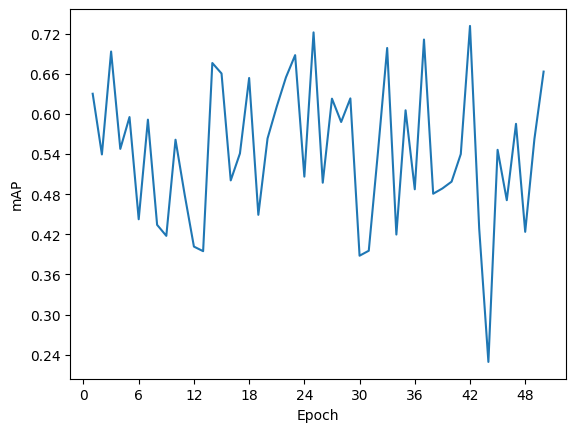

In [162]:
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
mAP_df = pd.DataFrame(mAPs, columns=['mAP'])
mAP_df.insert(0, 'Epoch', range(1, 1 + len(mAP_df)))


face_grid = sns.lineplot(data=mAP_df, x="Epoch", y="mAP")
fig = face_grid.figure
ax = fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

In [17]:
# inspect data
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline

In [18]:
# define a configuration for the model
from keras import backend as K 
K.clear_session()
class sphericalConfig(Config):
	# define the name of the configuration
	NAME = "sphericalConfig"
	# number of classes (background + irreg_organoid)
	NUM_CLASSES = 1 + 1
	# number of training steps per epoch
	STEPS_PER_EPOCH = 600
	STEPS_PER_EPOCH = len(dataset_train.image_ids)
	VALIDATION_STEPS = len(dataset_val.image_ids)
	IMAGES_PER_GPU  = 1
# Don't exclude based on confidence. Since we have two classes
# then 0.5 is the minimum anyway as it picks between nucleus and BG
	DETECTION_MIN_CONFIDENCE = 0.9
	DETECTION_NMS_THRESHOLD = 0.05       
	WEIGHT_DECAY = 0.001
	TRAIN_ROIS_PER_IMAGE = 600
	MAX_GT_INSTANCES = 50
	IMAGE_MIN_DIM = 512
	IMAGE_MAX_DIM = 512
	IMAGE_MIN_SCALE = 2.0
	LEARNING_RATE = 0.0005
	IMAGE_CHANNEL_COUNT = 1
	MEAN_PIXEL = int(overall_mean_pixel_value)
	USE_MINI_MASK=True
	IMAGE_RESIZE_MODE ='crop'
# Length of square anchor side in pixels
	RPN_ANCHOR_SCALES = (20, 80, 160,320,480)
	RPN_NMS_THRESHOLD = 0.9
	RPN_TRAIN_ANCHORS_PER_IMAGE = 600
	RPN_ANCHOR_STRIDE = 1 
	RPN_ANCHOR_RATIOS = [0.5,1,2]         
    
    
    
# prepare config
config = sphericalConfig()
config.display() 




Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.05
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [512 512   1]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0005
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

In [19]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)



anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  65472
Scales:  (20, 80, 160, 320, 480)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 49152
Anchors in Level 1: 12288
Anchors in Level 2: 3072
Anchors in Level 3: 768
Anchors in Level 4: 192


Level 0. Anchors:  49152  Feature map Shape: [128 128]
Level 1. Anchors:  12288  Feature map Shape: [64 64]
Level 2. Anchors:   3072  Feature map Shape: [32 32]
Level 3. Anchors:    768  Feature map Shape: [16 16]
Level 4. Anchors:    192  Feature map Shape: [8 8]


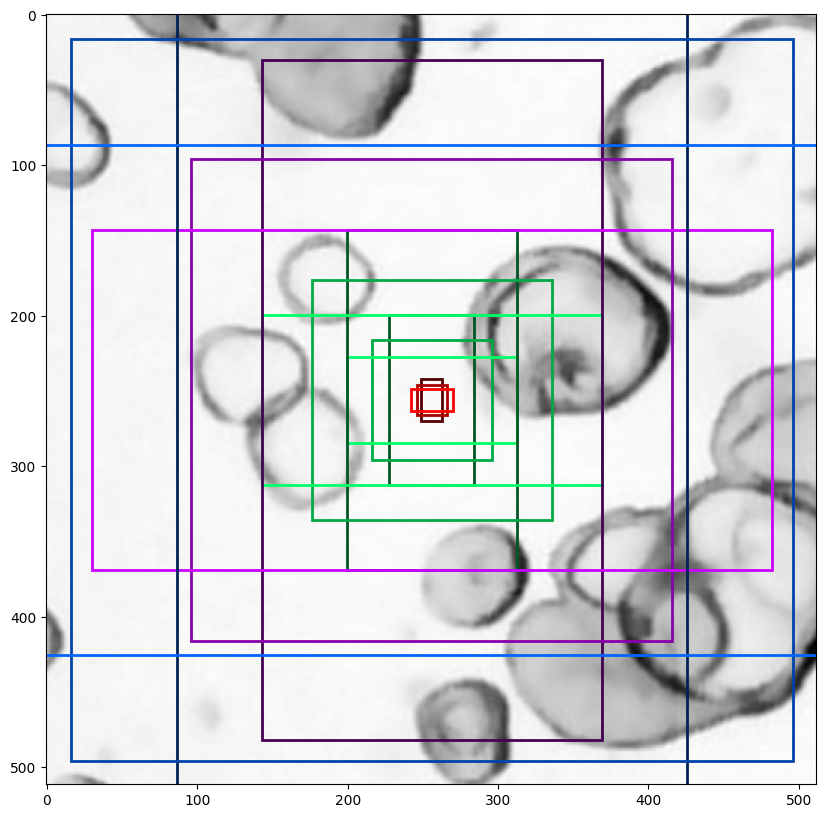

In [26]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset_train.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset_train, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image, cmap = 'gray')
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [512 512   1]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

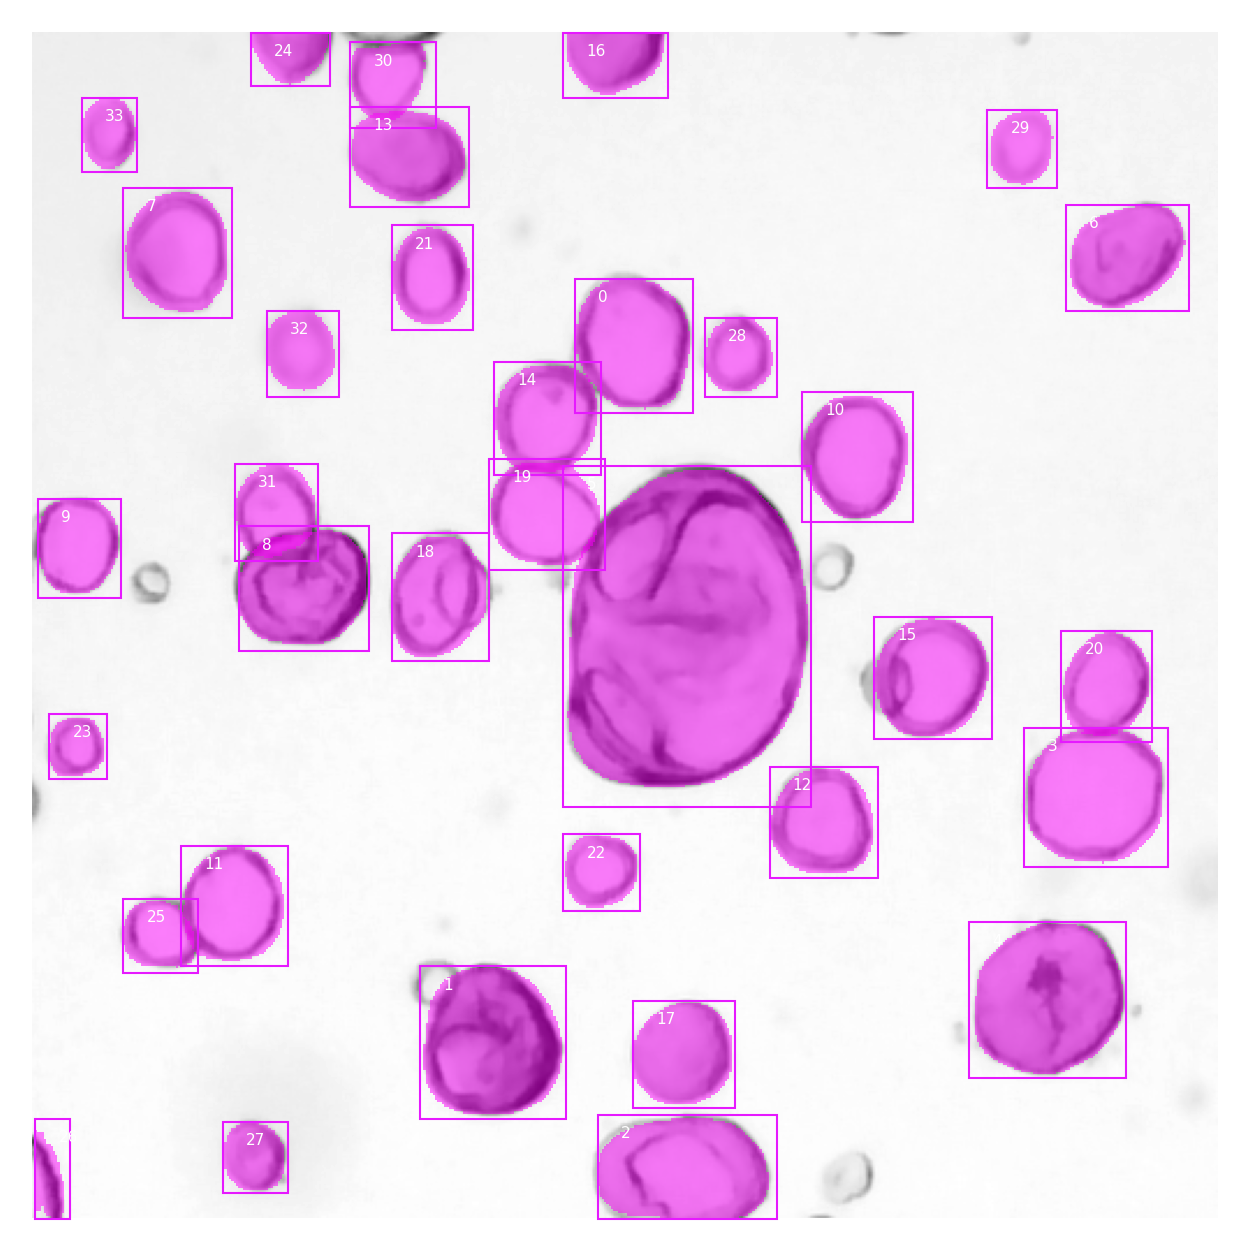

In [24]:
# evaluating tiling procedure

import cv2
import time
from IPython.display import clear_output
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib.patches import Rectangle
from mrcnn.model import MaskRCNN

ROOT_DIR = os.getcwd()
os.chdir(ROOT_DIR)
DEFAULT_LOGS_DIR = r'C:\Users\Standard User'
COCO_WEIGHTS_PATH =  r'C:\Users\Standard User\mask_rcnn_coco.h5'


marbles_img = cv2.imread(r"C:\Users\Standard User\Downloads\Spherical\tile1_resized.png",cv2.IMREAD_GRAYSCALE)

n=512
#round to multiple of 256
width = marbles_img.shape[1]
height = marbles_img.shape[0]

def myround(x, base=n):
    if x < n:
        return 512
    else:
        return base * math.floor(x/base)
width = myround(width)
height = myround(height)
resized = cv2.resize(marbles_img, (width,height), interpolation = cv2.INTER_AREA)

#expand dims
resized = np.expand_dims(resized, axis = -1)

    
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "spherical_cfg"
    # number of classes (background + Blue Marbles + Non Blue marbles)
    NUM_CLASSES = 1 + 1
    # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    # find the largest divisible number that is less than the max number of images possible per GPU
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7
    IMAGE_CHANNEL_COUNT = 1
    MEAN_PIXEL = mean(resized)
    USE_MINI_MASK=False
    IMAGE_RESIZE_MODE ='crop'
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_NMS_THRESHOLD = 0.3
    RPN_ANCHOR_SCALES = (20, 42, 90, 162, 400)
    #RPN_ANCHOR_SCALES = (20,80,160,320,480)
    #RPN_ANCHOR_SCALES = (32, 64, 128,256,512)
    RPN_TRAIN_ANCHORS_PER_IMAGE = 600
    RPN_ANCHOR_STRIDE = 1 
    RPN_ANCHOR_RATIOS = [0.5,1,2]         

# create config
cfg = PredictionConfig()
cfg.display()

# define the model
model = MaskRCNN(mode='inference', model_dir=DEFAULT_LOGS_DIR, config=cfg)
# load model weights
model.load_weights(r'E:\mask_rcnn\mask_rcnn_sphericalConfig_0022.h5', by_name=True)


detected = model.detect([resized])

list_of_colormaps = ['cool','cool']


def display_instances(image, boxes, masks, positions, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, show_captions= True, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    positions: [list of (i,j) coordinates dictating the patch that was analysed]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    #colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(image.astype(np.uint8), cmap = 'gray')
    
    #masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        # generate colormap and color
        my_cmap = getattr(cm, random.choice(list_of_colormaps)).copy()
        my_cmap.set_under('k', alpha=0)
        color = my_cmap(0.9)

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1.5,
                                alpha=1, linestyle="solid",
                                edgecolor=color, facecolor='None')
            ax.add_patch(p)

        # Label
        if show_captions:
            ax.text(x1+10, y1 + 10, i,
                    color='w', size=11, backgroundcolor="none")

        # Mask
#         mask = masks[:, :, i]
#         if show_mask:
#             masked_image = apply_mask(masked_image, mask, positions[i], color)


        if show_mask:
            
            mask = masks[:,:,i]
            x = positions[i][0]
            y = positions[i][1]
            left = y
            right = width - left - n
            top = x
            bottom = height - top - n
            #print(top,bottom,left,right)
            plt.imshow(np.pad(mask, ((top, bottom), (left, right))), cmap=my_cmap, interpolation='none', clim=[0.9, 1], alpha = 0.5) 

        
    if auto_show:
        output_image = plt.show()
        
    return(output_image)
    



results = detected[0]
positions = [(0,0)]*len(results['rois'])
class_names = ['BG', 'irregular_organiod']
display_instances(marbles_img, results['rois'], results['masks'], positions,
                results['class_ids'], class_names, results['scores'])




In [10]:

def display_instances_final(image, boxes, masks, positions, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, show_captions= True, captions=None, save = None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    positions: [list of (i,j) coordinates dictating the patch that was analysed]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
#     else:
#         assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    #colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(image.astype(np.uint8), cmap = 'gray')

    if show_bbox:
        for i in range(N):
            # generate colormap and color
            cmap = plt.get_cmap('autumn')
            cmap.set_under('k', alpha=0)
            color = cmap(0.5)

            # Bounding box
            if not np.any(boxes[i]):
                # Skip this instance. Has no bbox. Likely lost in image cropping.
                continue
            y1, x1, y2, x2 = boxes[i]
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1.5,
                                alpha=1, linestyle="solid",
                                edgecolor=color, facecolor='None')
            ax.add_patch(p)

            # Label
            if show_captions:
                ax.text(x1+10, y1 + 10, i,
                        color='red', size=11, backgroundcolor="none")


    if show_mask:
        resulting_mask = []

        for i,patch_coord in enumerate(sorted(set(positions))):
            mask_indices = [i for i, x in enumerate(positions) if x == patch_coord]
            patch_mask_stack =  []
            for mask_index in mask_indices:
                color = list(np.random.choice(range(1,256), size=1))
                mask = masks[...,mask_index].astype('uint8')
                mask[mask > 0] = color
                patch_mask_stack.append(mask)
            patch_mask_stack = np.stack(patch_mask_stack, axis = 2)
            patch_mask_stack = patch_mask_stack.max(axis = (2))
            x = patch_coord[0]
            y = patch_coord[1]
            left = y
            right = width - left
            top = x
            bottom = height - top
            patch_mask_stack = np.pad(patch_mask_stack, ((top, bottom), (left, right)))
            resulting_mask.append(patch_mask_stack)
        resulting_mask = np.stack(resulting_mask, axis = 2)
        resulting_mask = resulting_mask.max(axis = (2))
        
        cmap = plt.get_cmap('autumn')
        cmap.set_under('k', alpha=0)
        ax.imshow(resulting_mask.astype('uint8'),cmap = cmap, vmin = 0.1, alpha = 0.4)        
    if save:
        plt.savefig(image_path[:-4] + '_detected_output.png', dpi='figure', format='png', bbox_inches='tight', pad_inches=0)
    if auto_show:
        output_image = plt.show()
    plt.close()

        
    return(output_image)

In [ ]:
# modified inference pipeline - errors in detecting overlap fixed

import cv2
import time
from IPython.display import clear_output
from mrcnn import utils
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib import patches,  lines
import matplotlib.cm as cm
from matplotlib.patches import Polygon, Rectangle
from mrcnn.model import MaskRCNN
import os
import sys
import random
import itertools
import colorsys
import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
import time
import itertools
from datetime import timedelta
import pandas as pd
from keras import backend as K 

start_time = time.time()

K.clear_session()
#define start time of code
ROOT_DIR = os.getcwd()
os.chdir(ROOT_DIR)
DEFAULT_LOGS_DIR = r'C:\Users\Standard User'
COCO_WEIGHTS_PATH =  r'C:\Users\Standard User\mask_rcnn_coco.h5'


#get all paths of images of interest
image_paths = [x for x in glob.glob(r"H:\EVOS\stitched\*.png")]
print(image_paths)

#initate the loop
for yyy,image_path in enumerate(image_paths):
    clear_output(wait = True)
    print('Analyzing image ' + str(yyy + 1) + ' out of ' + str(len(image_paths)))
    #load the image
    # IMPORTANT: load image using the cv2 grayscale and not the skimage.io.read grayscale as this is not comptabile
    organoid_image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    if len(organoid_image.shape) > 3:
        organoid_image = organoid_image.squeeze()
    
    step_n=512
    n=512
    fraction_of_frame_to_step = 2
    #round to multiple of 256
    width = organoid_image.shape[1]
    height = organoid_image.shape[0]

    def myround(x, base=n):
        if x < n:
            return 512
        else:
            return base * math.floor(x/base)
    width = myround(width)
    height = myround(height)
    resized = cv2.resize(organoid_image, (width,height), interpolation = cv2.INTER_AREA)

    fraction_of_frame_to_step = 2

    # generate position ids 
    height_coords = list(range(0, height, int(step_n/fraction_of_frame_to_step)))
    width_coords = list(range(0, width, int(step_n/fraction_of_frame_to_step)))
    coords_list = [(i,j) for i in height_coords for j in width_coords] 

    # generate 4d array composed of 512x512 image patches of resuzed
    patchez = [resized[i:i+step_n, j:j+step_n] for i,j in coords_list]
    
    patchez = [x for x in patchez if x.shape[0] == 512 and x.shape[1] == 512]

    #exapnd dimensions of images to allow for the 4d images required by mask rcnn
    patchez = [np.expand_dims(x,axis=-1) for x in patchez]

    image_patches = np.stack(patchez, axis = 0)
    number_of_images = image_patches.shape[0]

    # filter coordinate_list to match the above patches
    coords_list = [x for x in coords_list if width - x[1] != 256]
    coords_list = [x for x in coords_list if height - x[0] != 256]

    images_per_batch = max([x for x in range(1,number_of_images+1) if not number_of_images%x and x <=5])

    #define class with the images per batch
    class PredictionConfig(Config):
        # define the name of the configuration
        NAME = "spherical_cfg"
        # number of classes (background + Blue Marbles + Non Blue marbles)
        NUM_CLASSES = 1 + 1
        # Set batch size to 1 since we'll be running inference on
                # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
        GPU_COUNT = 1
        # find the largest divisible number that is less than the max number of images possible per GPU
        IMAGES_PER_GPU = images_per_batch
        DETECTION_MIN_CONFIDENCE = 0.6
        IMAGE_CHANNEL_COUNT = 1
        MEAN_PIXEL = mean(resized)
        USE_MINI_MASK=False
        IMAGE_RESIZE_MODE ='crop'
        IMAGE_MIN_DIM = 512
        IMAGE_MAX_DIM = 512
        DETECTION_NMS_THRESHOLD = 0.3
        RPN_ANCHOR_SCALES = (20,q1,q3,whisker_high,400)
        #RPN_ANCHOR_SCALES = (20,80,160,320,480)
        #RPN_ANCHOR_SCALES = (32, 64, 128,256,512)
        RPN_TRAIN_ANCHORS_PER_IMAGE = 600
        RPN_ANCHOR_STRIDE = 1 
        RPN_ANCHOR_RATIOS = [0.5,1,2]        


    # create config
    cfg = PredictionConfig()
    #cfg.display()

    # define the model
    model = MaskRCNN(mode='inference', model_dir=DEFAULT_LOGS_DIR, config=cfg)
    # load model weights
    model.load_weights(r'E:\mask_rcnn\mask_rcnn_irregularconfig_0025.h5', by_name=True)


    itr = int(number_of_images/images_per_batch)

    patch_num=1
    positions = []
    rois_list = []
    masks = []
    class_ids = []
    scores = []

    detections = []
    for i in range(0,itr):
        print('Processing batch:', str(i))
        detected = model.detect(image_patches[int((i*images_per_batch)):int((i*images_per_batch)+images_per_batch), :, :,:])
        detections.append(detected)
    detections = [item for sublist in detections for item in sublist] 



    def append_coords(l,x,y):
        l[0] += x
        l[1] += y
        l[2] += x
        l[3] += y
        return l

    # define the limits of the new resized image which all image patches should find themselves within

    x_limits = resized.shape[0] - 512
    y_limits = resized.shape[1] - 512


    #find 'true' patches i.e. those that exist in the image without takings steps
    # generate position ids 
    true_height_coords = list(range(0, height, step_n))
    true_width_coords = list(range(0, width, step_n))
    true_coords_list = [(i,j) for i in true_height_coords for j in true_width_coords] 

    #find true coords indicies in coord_list
    true_coords_indicies = [coords_list.index(x) for  x in true_coords_list]


    from shapely.geometry import Point, Polygon

    #defining overlap calculation functions
    def NMS_alg(bbox1,bbox2):
        OBW = max(bbox1[1], bbox2[1]) - min(bbox1[3], bbox2[3])
        OBH = max(bbox1[0], bbox2[0]) - min(bbox1[2], bbox2[2])
        bbox1_area = (bbox1[3]-bbox1[1])*(bbox1[2]-bbox1[0])
        bbox2_area = (bbox2[3]-bbox2[1])*(bbox2[2]-bbox2[0])

        overlap_box1 = (OBW*OBH)/bbox1_area
        overlap_box2 = (OBW*OBH)/bbox2_area
        return(overlap_box1,overlap_box2,bbox1_area,bbox2_area)

    def check_overlap(bbox1,bbox2):
        polygon1 = Polygon([(bbox1[1],bbox1[0]), (bbox1[3],bbox1[0]), (bbox1[3],bbox1[2]), (bbox1[1],bbox1[2])])
        p1 = Point(bbox2[1],bbox2[0])
        p2 = Point(bbox2[3],bbox2[2])

        polygon2 = Polygon([(bbox2[1],bbox2[0]), (bbox2[3],bbox2[0]), (bbox2[3],bbox2[2]), (bbox2[1],bbox2[2])])
        p3 = Point(bbox1[1],bbox1[0])
        p4 = Point(bbox1[3],bbox1[2])

        if p1.within(polygon1) or p2.within(polygon1) or p1.touches(polygon1) or p2.touches(polygon1) or p3.within(polygon2) or p4.within(polygon2) or p3.touches(polygon2) or p4.touches(polygon2) or p1.distance(p3) < 20 or p2.distance(p4) < 20:
            return NMS_alg(bbox1,bbox2)



        # fix the coordinates of each bounding box so that they map to the original image
    for i in range(len(detections)):
        patch_starting_coords = coords_list[i]

        # fix the coordinates of the bboxes to account for position of patch on image
        for bbox_index in range(len(detections[i]['rois'])):
            x = patch_starting_coords[0]
            y = patch_starting_coords[1]
            detections[i]['rois'][bbox_index] = [detections[i]['rois'][bbox_index][0]+x,
                                                   detections[i]['rois'][bbox_index][1]+y,
                                                   detections[i]['rois'][bbox_index][2]+x,
                                                   detections[i]['rois'][bbox_index][3]+y]



    for i in range(len(coords_list)):
        # get patch coordinates
        patch_coordinates = coords_list[i]
        #get adjacent patches
        adj_right_patch = (patch_coordinates[0],patch_coordinates[1]+256)
        if adj_right_patch[0] > x_limits or adj_right_patch[1] > y_limits or adj_right_patch[0] < 0 or adj_right_patch[1] < 0:
            adj_right_patch = None
        adj_left_patch = (patch_coordinates[0],patch_coordinates[1]-256)
        if adj_left_patch[0] > x_limits or adj_left_patch[1] > y_limits or adj_left_patch[0] < 0 or adj_left_patch[1] < 0:
            adj_left_patch = None
        adj_down_patch = (patch_coordinates[0]+256,patch_coordinates[1])
        if adj_down_patch[0] > x_limits or adj_down_patch[1] > y_limits or adj_down_patch[0] < 0 or adj_down_patch[1] < 0:
            adj_down_patch = None
        adj_top_patch = (patch_coordinates[0]-256,patch_coordinates[1])
        if adj_top_patch[0] > x_limits or adj_top_patch[1] > y_limits or adj_top_patch[0] < 0 or adj_top_patch[1] < 0:
            adj_top_patch = None
        adj_diag_down_right_patch = (patch_coordinates[0]+256,patch_coordinates[1] + 256)
        if adj_diag_down_right_patch[0] > x_limits or adj_diag_down_right_patch[1] > y_limits or adj_diag_down_right_patch[0] < 0 or adj_diag_down_right_patch[1] < 0:
            adj_diag_down_right_patch = None
        adj_diag_down_left_patch = (patch_coordinates[0]+256,patch_coordinates[1] - 256)
        if adj_diag_down_left_patch[0] > x_limits or adj_diag_down_left_patch[1] > y_limits or adj_diag_down_left_patch[0] < 0 or adj_diag_down_left_patch[1] < 0:
            adj_diag_down_left_patch = None
        adj_diag_up_right_patch = (patch_coordinates[0]-256,patch_coordinates[1] + 256)
        if adj_diag_up_right_patch[0] > x_limits or adj_diag_up_right_patch[1] > y_limits or adj_diag_up_right_patch[0] < 0 or adj_diag_up_right_patch[1] < 0:
            adj_diag_up_right_patch = None
        adj_diag_up_left_patch = (patch_coordinates[0]-256,patch_coordinates[1] - 256)
        if adj_diag_up_left_patch[0] > x_limits or adj_diag_up_left_patch[1] > y_limits or adj_diag_up_left_patch[0] < 0 or adj_diag_up_left_patch[1] < 0:
            adj_diag_up_left_patch = None

        adjacent_patches = [adj_right_patch,adj_left_patch,adj_down_patch,adj_top_patch,adj_diag_down_right_patch,adj_diag_down_left_patch,adj_diag_up_right_patch,adj_diag_up_left_patch]
        #remove Nones
        adjacent_patches = [x for x in adjacent_patches if x is not None]
        # find indicies of patches in coordinate list
        adjacent_patch_indicies = [coords_list.index(x) for  x in adjacent_patches]


        for overlapping_index in adjacent_patch_indicies:



            # check overlap
            overlapping_losers_1 = []
            overlapping_losers_2 = []

            for bbox1 in range(len(detections[i]['rois'])):
                for bbox2 in range(len(detections[int(overlapping_index)]['rois'])):
                    overlap = check_overlap(detections[i]['rois'][bbox1],detections[int(overlapping_index)]['rois'][bbox2])
                    if overlap != None:
                        if overlap[0] > 0.3 or overlap[1] > 0.3:
                            # get areas
                            if overlap[2] > overlap[3]:
                                overlapping_losers_2.append(bbox2)
                            else:
                                overlapping_losers_1.append(bbox1)


            for index in sorted(set(overlapping_losers_1), reverse=True):
                detections[i]['rois'] = np.delete(detections[i]['rois'], index, 0)
                detections[i]['class_ids'] = np.delete(detections[i]['class_ids'] , index, 0)
                detections[i]['scores'] = np.delete(detections[i]['scores'], index, 0)
                detections[i]['masks'] = np.delete(detections[i]['masks'], index, 2)
                #real_patch_positions = np.delete(real_patch_positions, index, 0)
            for index in sorted(set(overlapping_losers_2), reverse=True):
                detections[int(overlapping_index)]['rois'] = np.delete(detections[int(overlapping_index)]['rois'], index, 0)
                detections[int(overlapping_index)]['class_ids'] = np.delete(detections[int(overlapping_index)]['class_ids'], index, 0)
                detections[int(overlapping_index)]['scores'] = np.delete(detections[int(overlapping_index)]['scores'], index, 0)
                detections[int(overlapping_index)]['masks'] = np.delete(detections[int(overlapping_index)]['masks'], index, 2)  
                #fixed_adj_positions = np.delete(overlapping_patch_positions, index, 0)



    #generate positions list 
    detection_positions = []

    for i,patch in enumerate(detections):
        patch_positions = [coords_list[i]]*len(patch['rois'])
        detection_positions.append(patch_positions)
    detection_positions = [item for sublist in detection_positions for item in sublist]


    fixed_detections = {}

    for k in set(k for d in detections for k in d):
        fixed_detections[k] = [d[k] for d in detections if k in d]

    fixed_detections['rois'] = np.array([item for sublist in fixed_detections['rois'] for item in sublist])
    fixed_detections['scores'] = np.array([item for sublist in fixed_detections['scores'] for item in sublist])
    fixed_detections['class_ids'] = np.array([item for sublist in fixed_detections['class_ids'] for item in sublist])
    fixed_detections['masks'] = np.dstack(fixed_detections['masks'])


    display_instances_final(resized,
                      boxes = fixed_detections['rois'], 
                      masks = fixed_detections['masks'], 
                      positions = detection_positions,
                      class_ids = fixed_detections['class_ids'],
                      scores =  fixed_detections['scores'],
                      class_names = dataset_train.class_names,
                      show_captions = True,
                      show_bbox = True,
                     show_mask = True,
                           save = True)
    mask_areas = [np.sum(fixed_detections['masks'][:,:,i] > 0) for i in range(fixed_detections['masks'].shape[2])]
    indexes = [item for item in range(0, fixed_detections['masks'].shape[2]+1)]

    df_output = pd.DataFrame(list(zip(indexes, mask_areas)),columns=['Organoid_ID','Area (pixels)'])
    df_output.to_csv(image_path[:-4] + '_detected_output.csv',index=False)
    #clear session prior to moving onto next image
    K.clear_session()

print(time.time()-start_time)

Analyzing image 2 out of 8
Processing batch: 0
Processing batch: 1
Processing batch: 2
Processing batch: 3
Processing batch: 4
Processing batch: 5
Processing batch: 6
Processing batch: 7
Processing batch: 8
